In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tüfe=pd.read_csv("tüfe.csv",index_col=0)
tüfe.index=pd.to_datetime(tüfe.index)
endeksler=pd.read_csv("endeksler.csv",index_col=0)
endeksler.index=pd.to_datetime(endeksler.index)
harcama_grupları=pd.read_csv("harcama_grupları.csv",index_col=0)
harcama_grupları.index=pd.to_datetime(harcama_grupları.index)
özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)



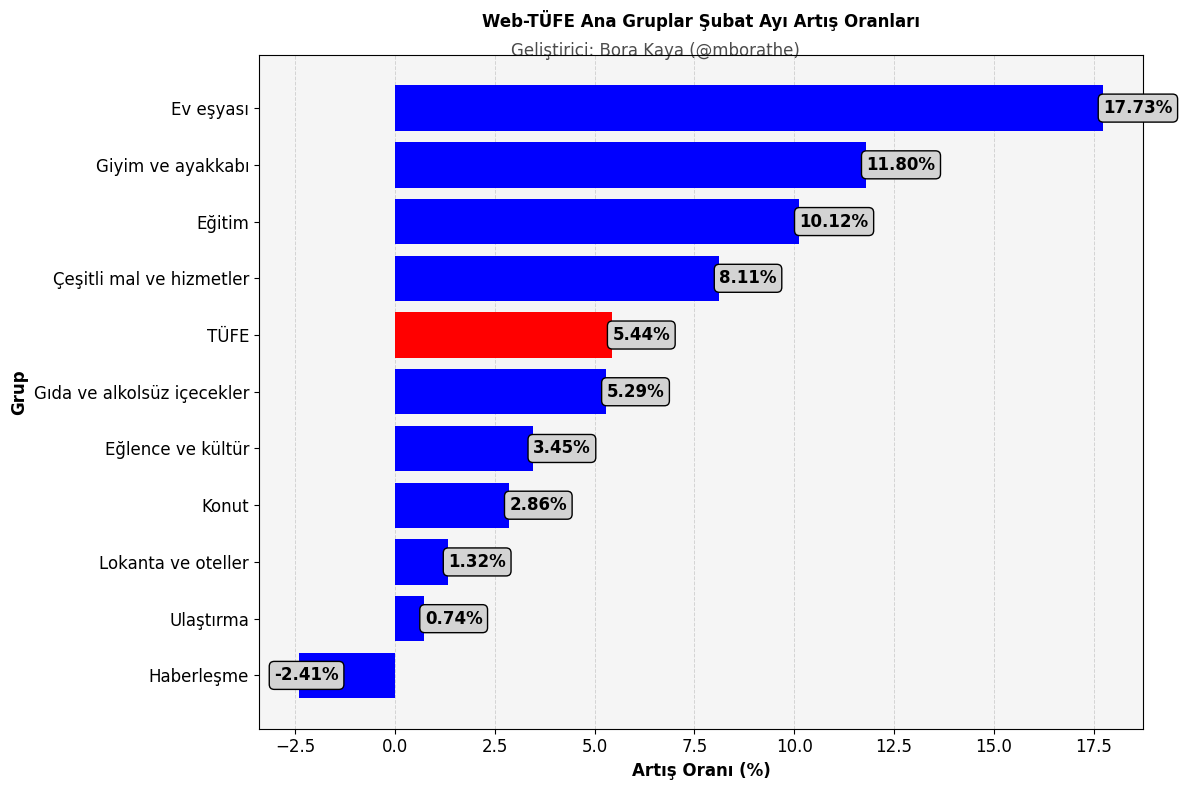

In [2]:
def hareketli_aylik_ortalama(df):
    
        değer = df.name  # Kolon ismi
        df = pd.DataFrame(df)
        df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
        df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
        
        # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
        df["Aylık Ortalama"] = (
            df[df["Gün Sırası"] <= 24]
            .groupby(df["Tarih"].dt.to_period("M"))[değer]
            .expanding()
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        # Orijinal indeksi geri yükle
        df.index = pd.to_datetime(df.index)
        return df

from datetime import datetime,timedelta
import pytz
tüfe=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe-streamlit/tüfe.csv",index_col=0)
tüfe.index=pd.to_datetime(tüfe.index)

gruplar=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe-streamlit/gruplar_int.csv",index_col=0)
gruplar.index=pd.to_datetime(gruplar.index)
gfe1=tüfe.copy()
gfe1["Date"]=pd.to_datetime(gfe1.index)
gfe1["Ay"]=gfe1["Date"].dt.month
gfe1["Yıl"]=gfe1["Date"].dt.year    
month = gfe1["Ay"].iloc[-1]
year=gfe1["Yıl"].iloc[-1] 
oncekiyear=gfe1["Yıl"].iloc[-1] 
tarihim=pd.to_datetime(gfe1.index[-1]).day
if tarihim>24:
    tarihim=24
if tarihim<10:
    tarihim="0"+str(tarihim)

from datetime import datetime,timedelta
tarih=datetime.now().strftime("%Y-%m")
onceki=(datetime.now()-timedelta(days=31)).strftime("%Y-%m")

harcama_artıs=pd.Series(index=gruplar.columns)
for col in gruplar.columns:
    harcama_artıs.loc[col]=(((hareketli_aylik_ortalama(gruplar[col])["Aylık Ortalama"].fillna(method="ffill").iloc[-1]/hareketli_aylik_ortalama(gruplar[col])["Aylık Ortalama"].fillna(method="ffill").loc[f"{onceki}-{tarihim}"])-1)*100)

harcama_artıs=harcama_artıs.sort_values()

colors = ['red' if label == 'TÜFE' else 'blue' for label in harcama_artıs.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:42] for label in harcama_artıs.index]



colors = ['red' if label == 'TÜFE' else 'blue' for label in harcama_artıs.keys()]
shortened_index = [label[:42] for label in harcama_artıs.keys()]
values = list(harcama_artıs)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +1,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.3')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE Ana Gruplar Şubat Ayı Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=20)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Grup', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.55, 0.93, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()
plt.savefig("anagruplar.png", dpi=300)

plt.show()



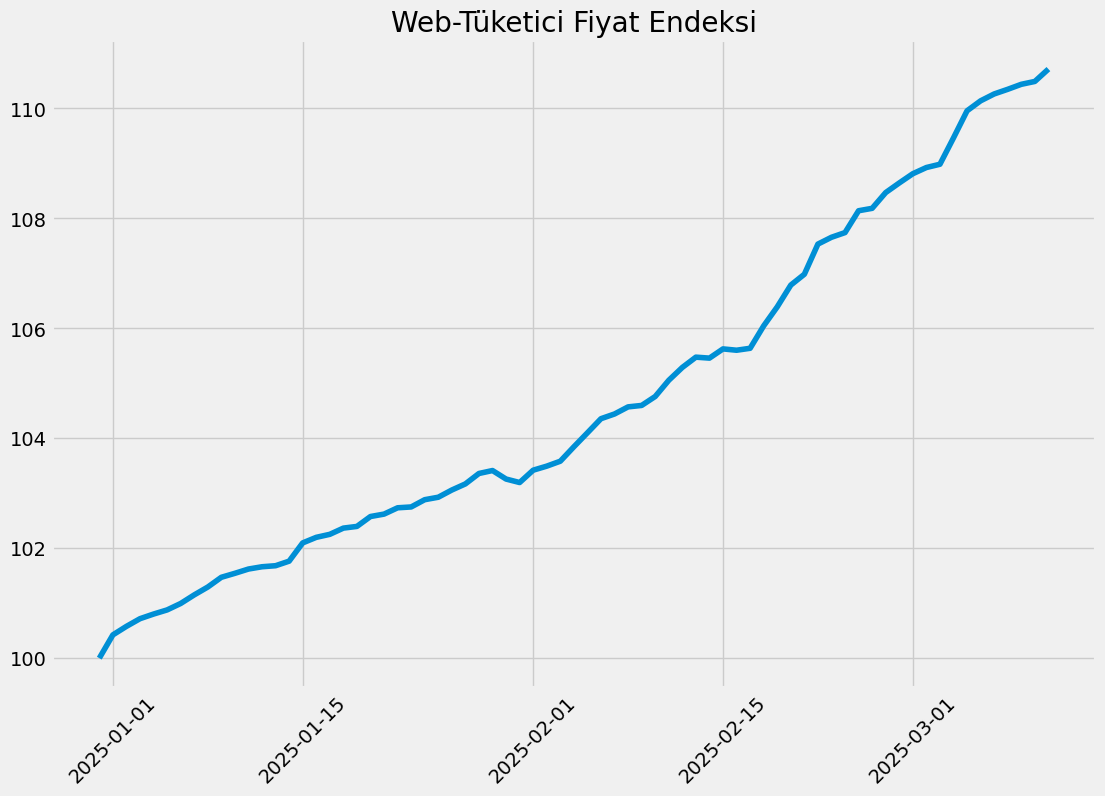

In [4]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.plot(tüfe,label="TÜFE")
plt.grid(True)
plt.xticks(rotation=45)
plt.title("Web-Tüketici Fiyat Endeksi")
plt.savefig("tüfe.png", dpi=300)

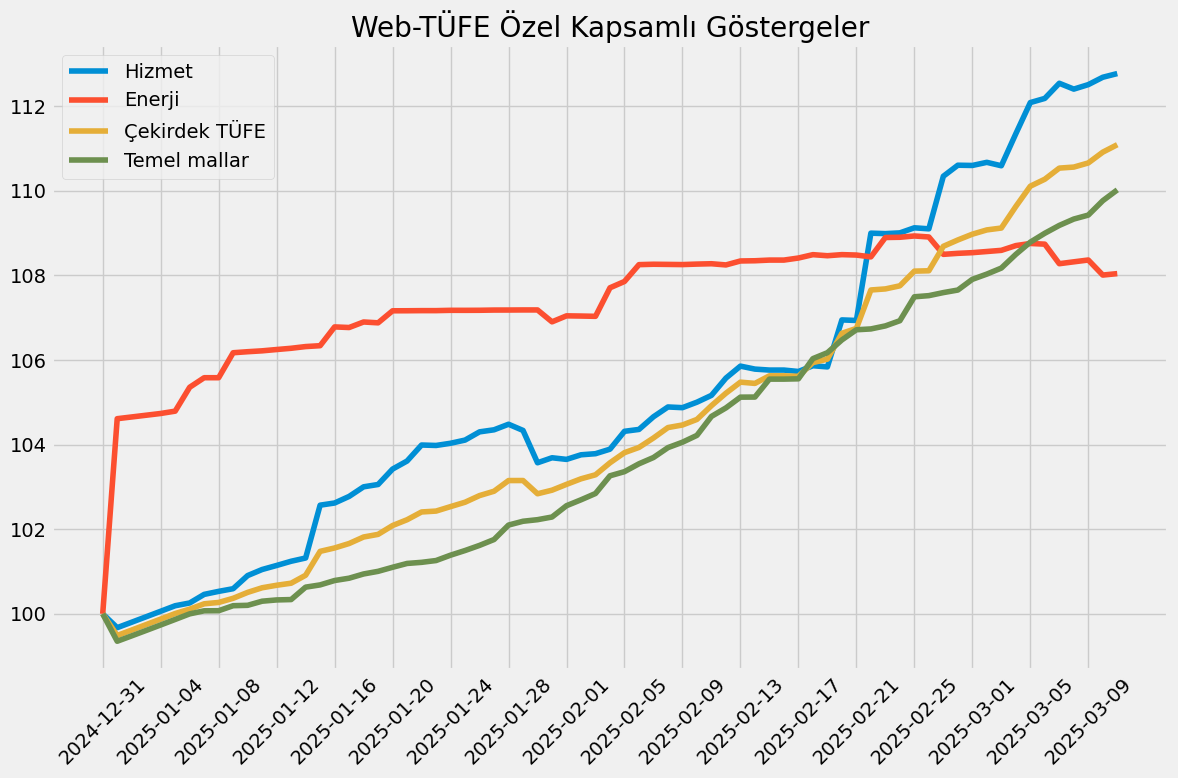

In [5]:
özelgöstergeler.loc[pd.to_datetime("2024-12-31")]=100
özelgöstergeler=özelgöstergeler.sort_index()
plt.figure(figsize=(12,8))
plt.title("Web-TÜFE Özel Kapsamlı Göstergeler")

plt.plot(özelgöstergeler["Hizmet"],label="Hizmet")
plt.plot(özelgöstergeler["Enerji"],label="Enerji")
plt.plot(özelgöstergeler["TÜFE C"],label="Çekirdek TÜFE")
plt.plot(özelgöstergeler["Temel mallar"],label="Temel mallar")
plt.legend()
plt.grid(True)
plt.xticks(özelgöstergeler.index[::4],rotation=45)
plt.tight_layout()
plt.savefig("özelgöstergeler.png", dpi=300)

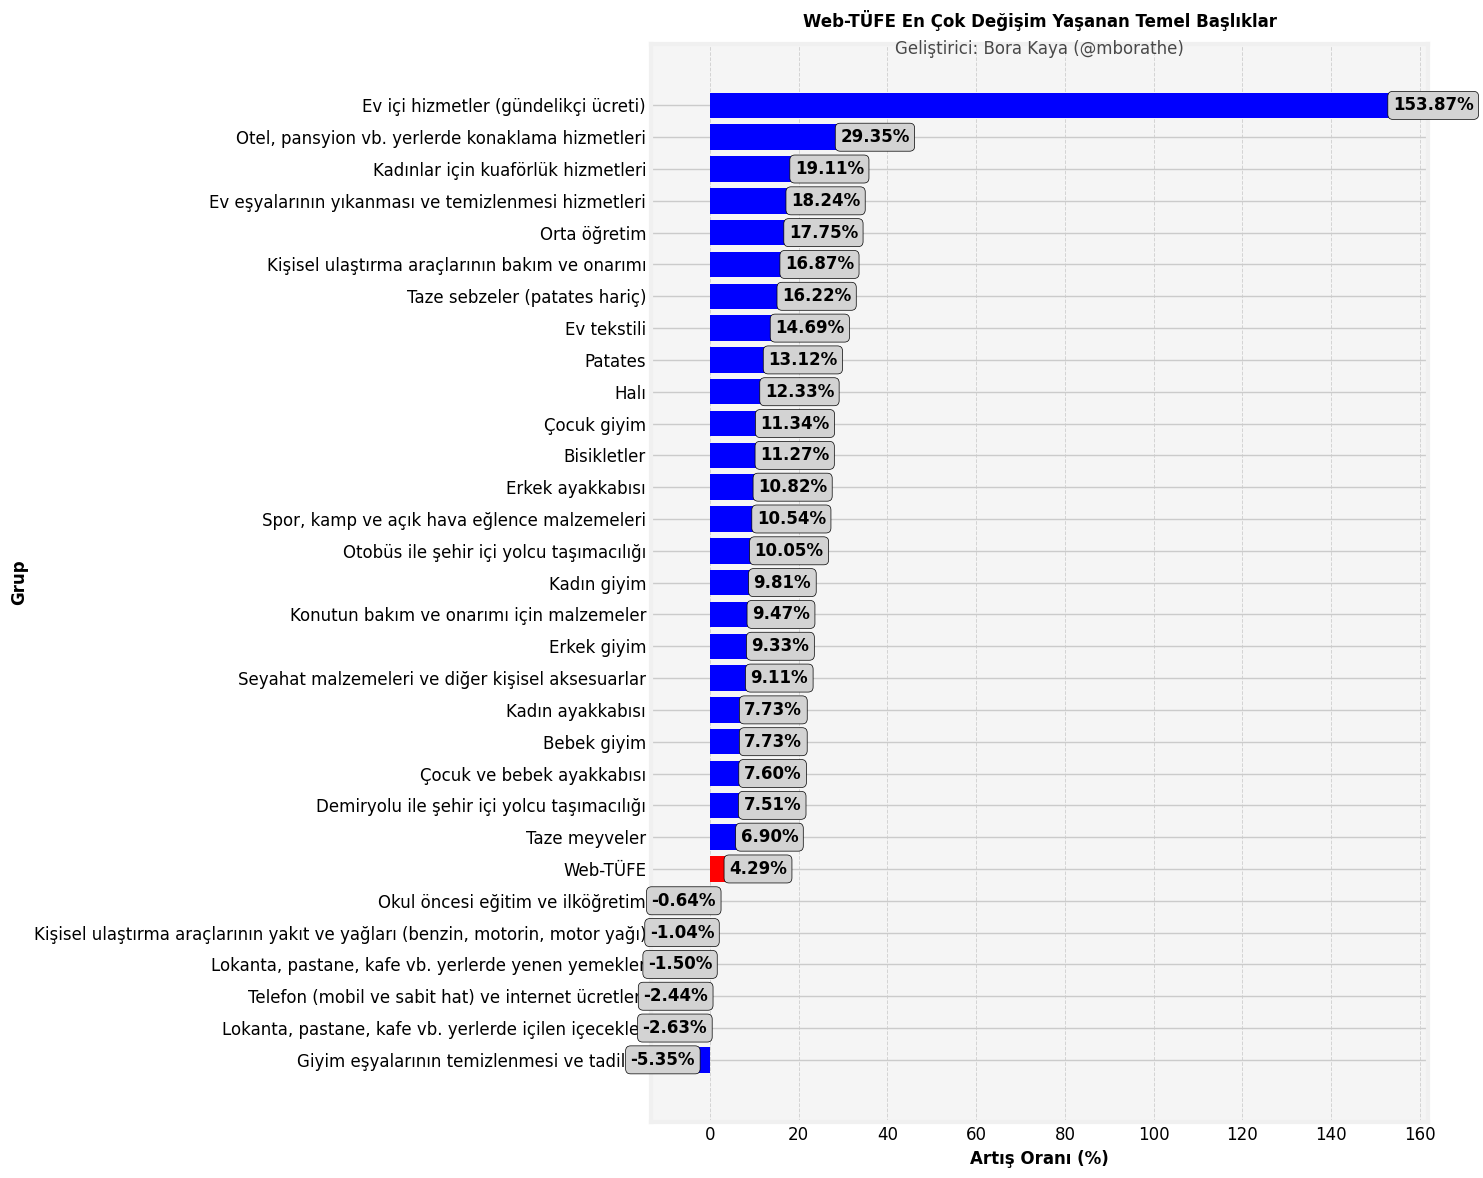

In [8]:
harcama_grupları=harcama_grupları.sort_index()
veri=pd.concat([(((harcama_grupları.loc["2025-03"].mean()/harcama_grupları.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().head(6),(((harcama_grupları.loc["2025-03"].mean()/harcama_grupları.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().tail(24)],axis=0)
veri.loc["Web-TÜFE"]=(((tüfe.loc["2025-03"].mean()/tüfe.loc["2025-02-01":"2025-02-24"].mean())-1)*100).values[0]
veri=veri.sort_values()

colors = ['red' if label == 'Web-TÜFE' else 'blue' for label in veri.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in veri.index]



shortened_index = [label[:100] for label in veri.keys()]
values = list(veri)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.3')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE En Çok Değişim Yaşanan Temel Başlıklar', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Grup', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.7, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig("temelbaşlıklar.png", dpi=300)



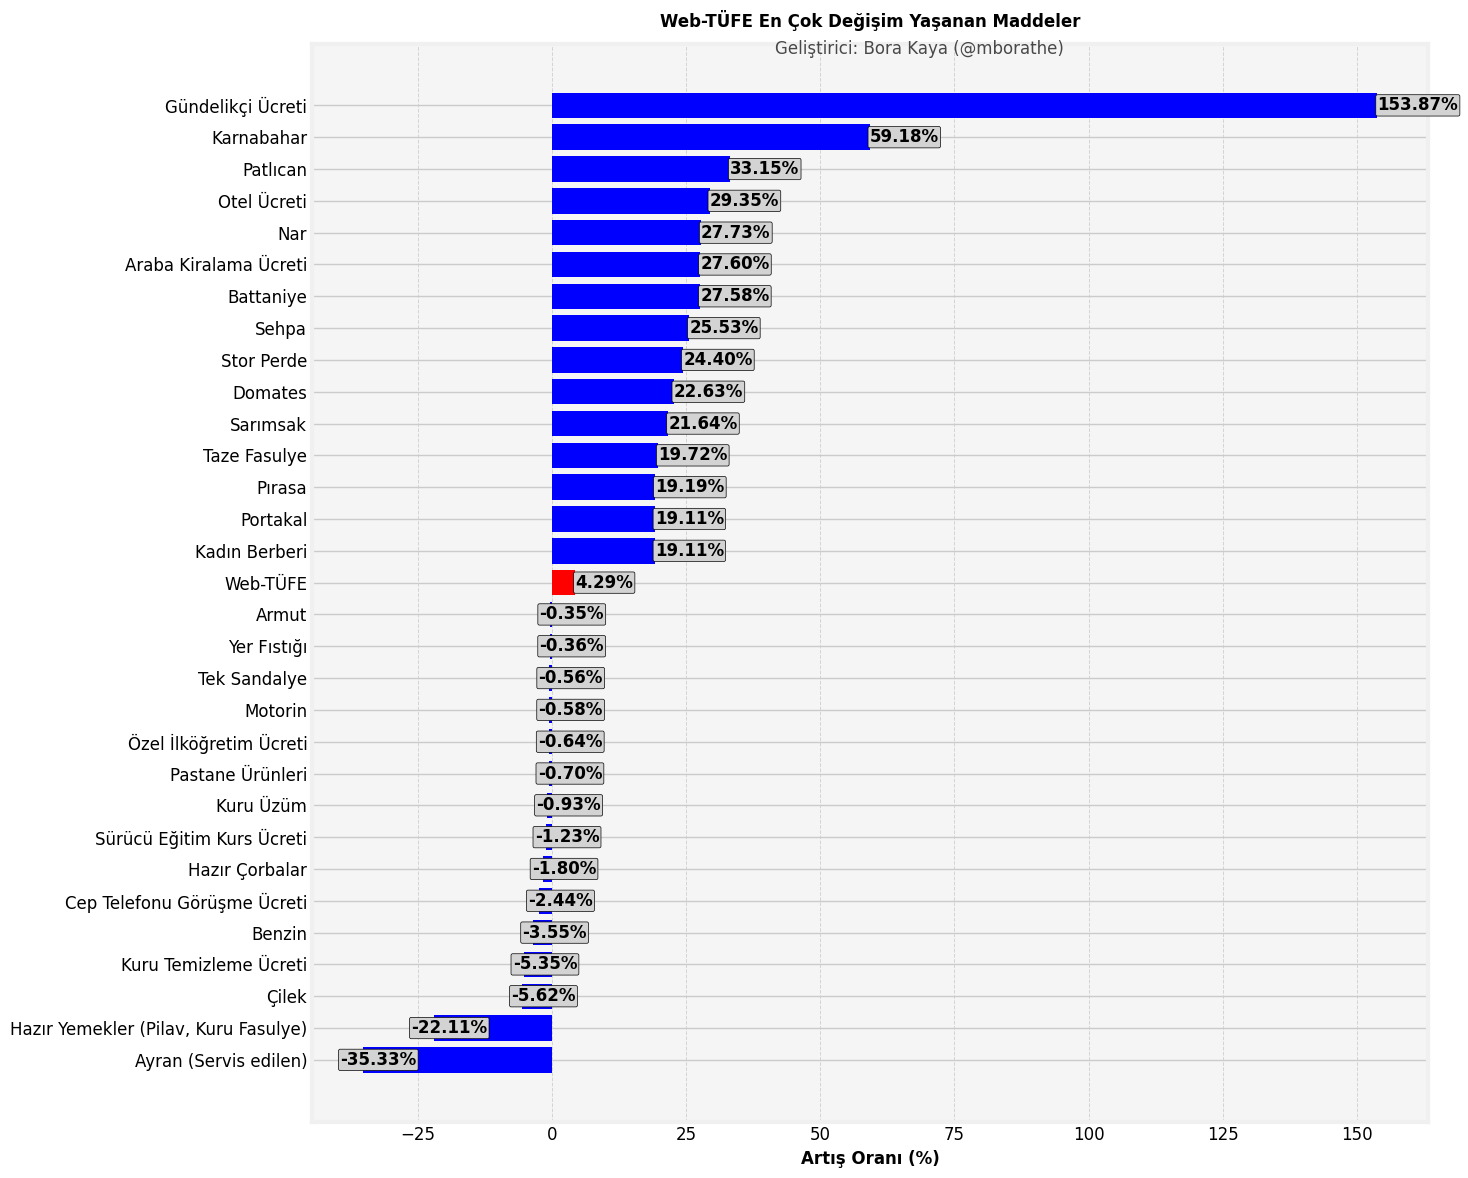

In [9]:
endeksler=endeksler.sort_index()
veri=pd.concat([(((endeksler.loc["2025-03"].mean()/endeksler.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().head(15),(((endeksler.loc["2025-03"].mean()/endeksler.loc["2025-02-01":"2025-02-24"].mean())-1)*100).sort_values().tail(15)],axis=0)
veri.loc["Web-TÜFE"]=(((tüfe.loc["2025-03"].mean()/tüfe.loc["2025-02-01":"2025-02-24"].mean())-1)*100).values[0]
veri=veri.sort_values()

colors = ['red' if label == 'Web-TÜFE' else 'blue' for label in veri.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in veri.index]



shortened_index = [label[:100] for label in veri.keys()]
values = list(veri)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +10,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE En Çok Değişim Yaşanan Maddeler', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.62, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig("maddeler.png", dpi=300)



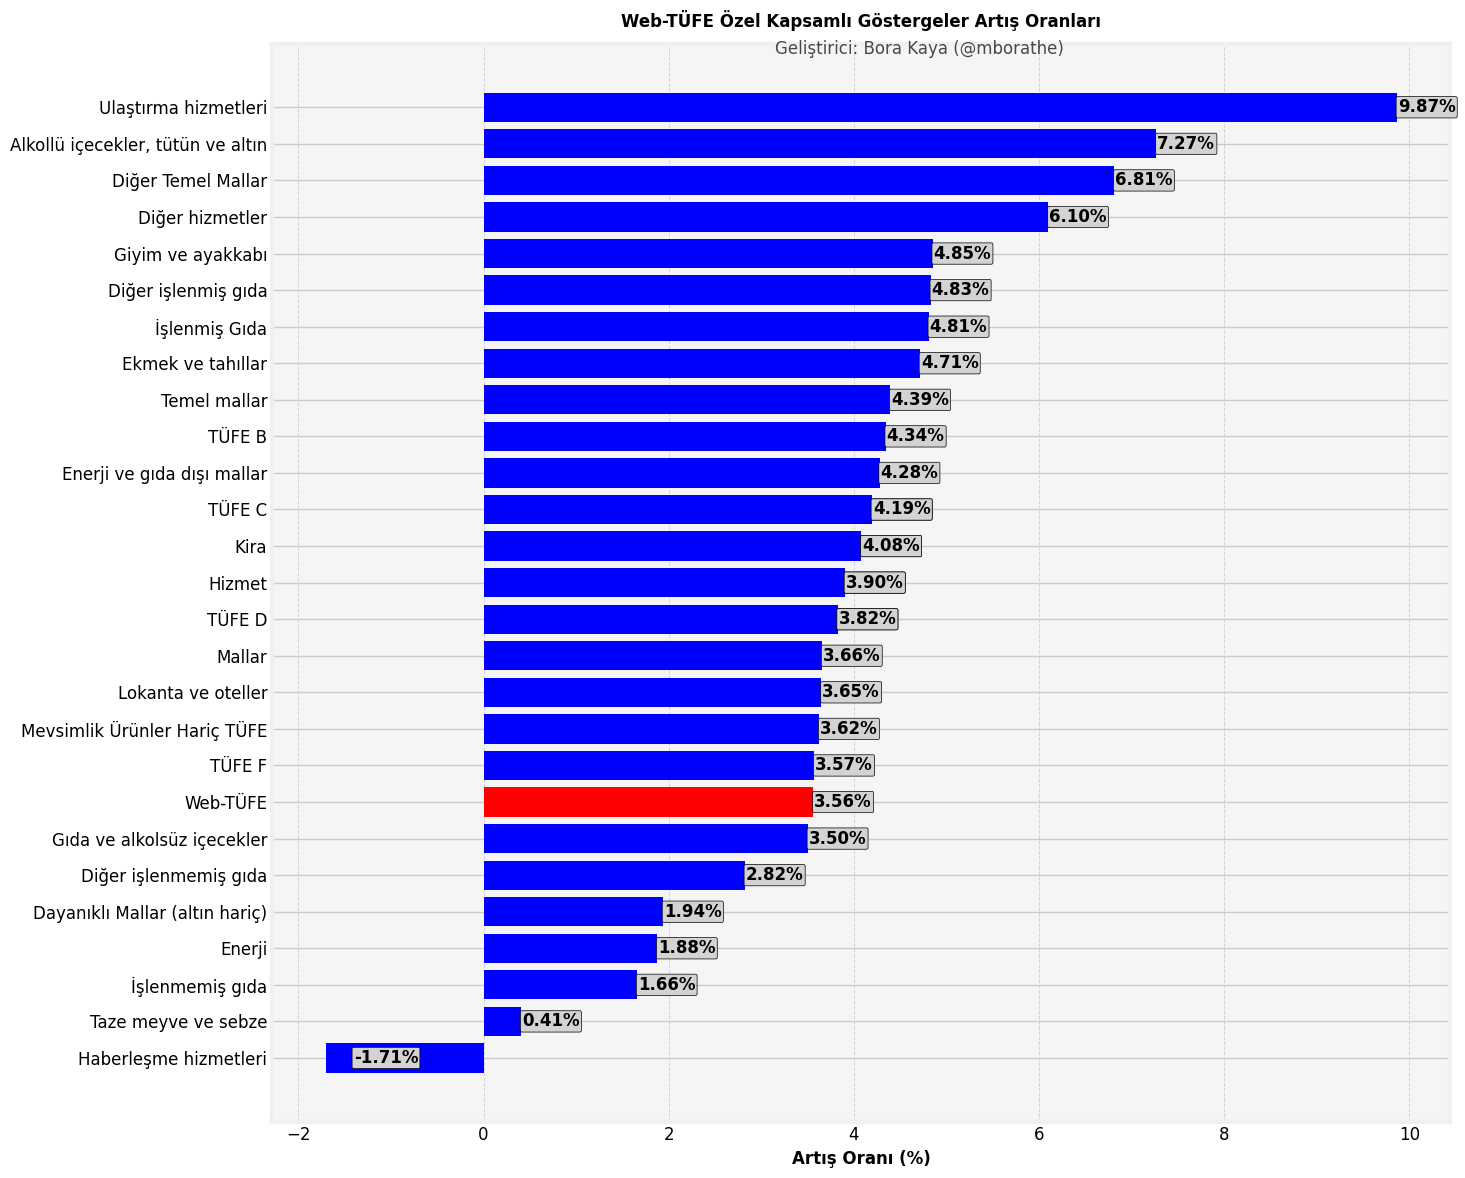

In [14]:
özelgöstergeler=özelgöstergeler.sort_index()
veri=pd.concat([(((özelgöstergeler.loc["2025-02"].mean()/özelgöstergeler.loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values().head(15),(((özelgöstergeler.loc["2025-02"].mean()/özelgöstergeler.loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values().tail(15)],axis=0)
veri.loc["Web-TÜFE"]=(((tüfe.loc["2025-02"].mean()/tüfe.loc["2025-01-01":"2025-01-24"].mean())-1)*100).values[0]
veri=veri.sort_values()

colors = ['red' if label == 'Web-TÜFE' else 'blue' for label in veri.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in veri.index]



shortened_index = [label[:100] for label in veri.keys()]
values = list(veri)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +1,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Web-TÜFE Özel Kapsamlı Göstergeler Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.62, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig("özelgöstergelerartış.png", dpi=300)



In [ ]:
özelgöstergeler["Alkollü içecekler, tütün ve altın"]

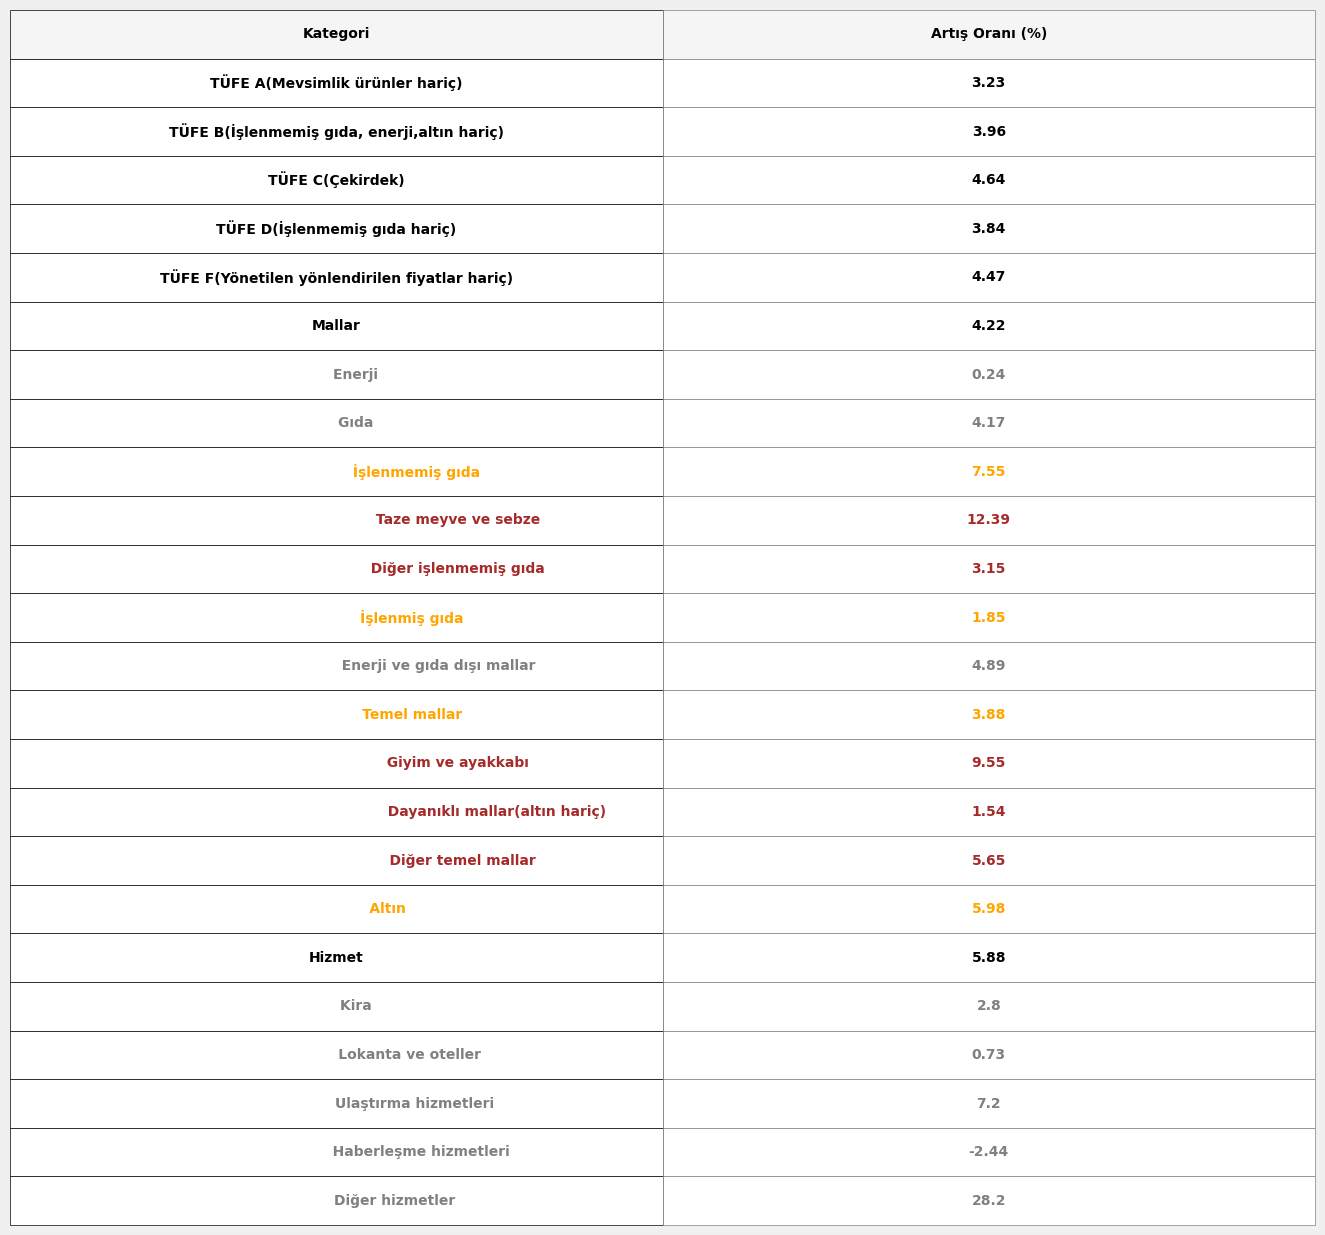

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
def artıshesapla(seri):
    artıs=(((özelgöstergeler[seri].loc["2025-03"].mean()/özelgöstergeler[seri].loc["2025-02-01":"2025-02-24"].mean())-1)*100)
    artıs=artıs.round(2)
    return artıs
    
# Veriyi tanımlayalım
data = {
    "Kategori": [
        "TÜFE A(Mevsimlik ürünler hariç)",
        "TÜFE B(İşlenmemiş gıda, enerji,altın hariç)",
        "TÜFE C(Çekirdek)",
        "TÜFE D(İşlenmemiş gıda hariç)",
        "TÜFE F(Yönetilen yönlendirilen fiyatlar hariç)",
        "Mallar",
        "        Enerji",
        "        Gıda",
        "                                 İşlenmemiş gıda",
        "                                                  Taze meyve ve sebze",
        "                                                  Diğer işlenmemiş gıda",
        "                               İşlenmiş gıda",
        "                                          Enerji ve gıda dışı mallar",
        "                               Temel mallar",
        "                                                  Giyim ve ayakkabı",
        "                                                                  Dayanıklı mallar(altın hariç)",
        "                                                    Diğer temel mallar",
        "                     Altın",
        "Hizmet",
        "        Kira",
        "                              Lokanta ve oteller",
        "                                Ulaştırma hizmetleri",
        "                                   Haberleşme hizmetleri",
        "                        Diğer hizmetler"
    ],
    "Artış Oranı (%)": [artıshesapla("Mevsimlik Ürünler Hariç TÜFE"),artıshesapla("TÜFE B"),artıshesapla("TÜFE C"),artıshesapla("TÜFE D"),artıshesapla("TÜFE F"),
                        artıshesapla("Mallar"),artıshesapla("Enerji"),artıshesapla("Gıda ve alkolsüz içecekler"), artıshesapla("İşlenmemiş gıda"), artıshesapla("Taze meyve ve sebze")
                        , artıshesapla("Diğer işlenmemiş gıda"), artıshesapla("İşlenmiş Gıda"),artıshesapla("Enerji ve gıda dışı mallar"),artıshesapla("Temel mallar"),artıshesapla("Giyim ve ayakkabı"),
                        artıshesapla("Dayanıklı Mallar (altın hariç)"),artıshesapla("Diğer Temel Mallar"),artıshesapla("Alkollü içecekler, tütün ve altın"),
                        artıshesapla("Hizmet"),artıshesapla("Kira"),artıshesapla("Lokanta ve oteller"),artıshesapla("Ulaştırma hizmetleri"),artıshesapla("Haberleşme hizmetleri"),artıshesapla("Diğer hizmetler")],
}

# Veriyi DataFrame'e dönüştürelim
df = pd.DataFrame(data)

# Tabloyu göster
fig, ax = plt.subplots(figsize=(15, 12))
ax.axis('off')  # Tabloyu temiz bir şekilde göstermek için eksenleri kapat

# Tabloyu çiz
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

# Tablo hücrelerine kenarlık ekleyerek hiyerarşiyi vurgulamak
for (i, j), cell in table.get_celld().items():
    cell.set_fontsize(35)
    if i == 0:
        cell.set_fontsize(35)
        cell.set_text_props(weight='bold')
        cell.set_fontsize(35)
    elif i==6 or i==19 or i==1 or i==2 or i==3 or i==4 or i==5:
        cell.set_text_props(color="black",weight='bold')
        cell.set_fontsize(35)
    elif i==7 or i==8 or i==13 or i==20 or i==21 or i==22 or i==23 or i==24 or i==25:
        cell.set_text_props(color="gray",weight='bold')
        cell.set_fontsize(25)
    elif i==9 or i==12 or i==14 or i==18:
        cell.set_text_props(color="orange",weight='bold')
        cell.set_fontsize(25)
    elif i==10 or i==11 or i==15 or i==16 or i==17:
        cell.set_text_props(color="brown",weight='bold')
        cell.set_fontsize(35)
    else:
        cell.set_fontsize(25)
    if j == 0:
        cell.set_edgecolor('black')  # Sadece sol kenarları belirginleştir
    else:
        cell.set_edgecolor('gray')  # Sağ kenarları daha hafif yapmak için

    cell.set_height(0.05)

# Grafik göster
plt.savefig("özelgöstergelerartış.png", dpi=300)


In [51]:
((harcama_grupları[['Evcil hayvanlarla ilgili veterinerlik ve diğer hizmetler',
 'Okul öncesi eğitim ve ilköğretim',
 'Orta öğretim',
 'Üniversite eğitimi',
 'Başka yerde sınıflandırılmayan diğer mali hizmetler (para havale ücreti vb.)','Erkekler için kuaförlük hizmetleri','Kadınlar için kuaförlük hizmetleri','Ev eşyalarının yıkanması ve temizlenmesi hizmetleri','Ev içi hizmetler (gündelikçi ücreti)',
 'Kişisel ulaştırma araçlarının bakım ve onarımı']].loc["2025-03"].mean()/harcama_grupları[['Evcil hayvanlarla ilgili veterinerlik ve diğer hizmetler',
 'Okul öncesi eğitim ve ilköğretim',
 'Orta öğretim',
 'Üniversite eğitimi',
 'Başka yerde sınıflandırılmayan diğer mali hizmetler (para havale ücreti vb.)','Erkekler için kuaförlük hizmetleri','Kadınlar için kuaförlük hizmetleri','Ev eşyalarının yıkanması ve temizlenmesi hizmetleri','Ev içi hizmetler (gündelikçi ücreti)',
 'Kişisel ulaştırma araçlarının bakım ve onarımı']].loc["2025-02-01":"2025-02-24"].mean())-1).sort_values()

Okul öncesi eğitim ve ilköğretim                                               -0.0064
Başka yerde sınıflandırılmayan diğer mali hizmetler (para havale ücreti vb.)   -0.0002
Erkekler için kuaförlük hizmetleri                                             -0.0002
Evcil hayvanlarla ilgili veterinerlik ve diğer hizmetler                       -0.0002
Üniversite eğitimi                                                              0.0205
Kişisel ulaştırma araçlarının bakım ve onarımı                                  0.1687
Orta öğretim                                                                    0.1775
Ev eşyalarının yıkanması ve temizlenmesi hizmetleri                             0.1824
Kadınlar için kuaförlük hizmetleri                                              0.1911
Ev içi hizmetler (gündelikçi ücreti)                                            1.5387
dtype: float64

In [31]:
ağırlıklar=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
ağırlıklar=ağırlıklar.sort_values(by="Ağırlık",ascending=False)
ağırlıklar

,Ağırlık,Ana Grup,Endeks_2024-12-31,Endeks_2025-01-06,Endeks_2025-01-07,Endeks_2025-01-09,Endeks_2025-01-10,Endeks_2025-01-11,Endeks_2025-01-12,Endeks_2025-01-13,...,Endeks_2025-03-02,Endeks_2025-03-03,Endeks_2025-03-04,Endeks_2025-03-05,Endeks_2025-03-06,Endeks_2025-03-07,Endeks_2025-03-08,Endeks_2025-03-09,Endeks_2025-03-10,Endeks_2025-03-11
Ürün,,,,,,,,,,,,,,,,,,,,,
Kiracı Tarafından Ödenen Gerçek Kira,0.082368,Konut,100.0,100.781640,100.969082,101.146928,101.318383,101.480153,101.641082,101.801584,...,108.191519,108.335905,108.532302,108.595065,108.963130,109.389715,109.303017,109.305528,109.465950,109.769650
Otomobil (Benzinli),0.076200,Ulaştırma,100.0,100.000000,100.212640,100.328435,100.350229,100.747392,100.747392,100.747392,...,101.752596,101.752596,101.752596,101.752596,101.752596,101.752596,101.752596,101.752596,102.347518,102.380325
Ekmek,0.026524,Gıda ve alkolsüz içecekler,100.0,99.984778,100.274465,100.020779,100.020779,100.020779,100.020779,100.020779,...,107.095019,107.124973,107.149167,107.204455,107.258602,107.267594,107.284285,107.300127,107.274661,107.489360
Dana Eti,0.025460,Gıda ve alkolsüz içecekler,100.0,101.039015,101.222732,100.890431,100.387579,100.387579,100.343092,100.343092,...,107.536150,107.539299,107.575146,107.574038,107.755022,108.050302,108.043394,108.236218,107.985053,108.705166
Su Faturası,0.023802,Konut,100.0,124.565952,124.565952,124.565952,124.565952,124.565952,124.565952,124.565952,...,127.881138,127.881138,129.746896,129.746896,129.746896,129.746896,129.746896,129.746896,129.746896,129.746896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kakao,0.000059,Gıda ve alkolsüz içecekler,100.0,103.541273,103.541273,103.541273,103.541273,103.541273,103.541273,103.541273,...,114.259455,114.259455,115.115349,114.992381,115.194520,115.011636,115.016546,115.017482,115.010116,115.484848
Köprü Geçiş Ücreti,0.000057,Ulaştırma,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,133.549870,...,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940,133.505940
Metro Ücreti,0.000036,Ulaştırma,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944,137.078944


In [32]:
seçilmiş=list(ağırlıklar.index[:30].drop(["Kiracı Tarafından Ödenen Gerçek Kira","Ekmek","Dana Eti","Cep Telefonu Görüşme Ücreti",'Doğalgaz Ücreti', 'Elektrik Ücreti','Tavuk Eti','Kuzu Eti',
       'Ayçiçek Yağı','Çamaşır İçin Temizlik ve Bakım Ürünleri','Beyaz Peynir', 'Yumurta',"Çay"]).values)
seçilmiş.extend(["Televizyon","Özel İlköğretim Ücreti","Otel Ücreti","No-Frost Buzdolabı","Çamaşır Makinesi","Tüp Gaz Ücreti","Gündelikçi Ücreti","Motorsiklet","Yatak Odası Takımı","Erkek Berberi",
                 "Çorbalar","Spor Ayakkabısı (Erkek için)","Pizzalar","Kadın Berberi","Derin Dondurucu","Elektrikli Süpürge","Bulaşık Makinesi","Spor Ayakkabısı (Kadın için)","Tek Masa","Test Kitapları","Bilgisayar","Yemek Odası Takımı","Yatak (Çift Kişilik)","Sürücü Eğitim Kurs Ücreti","Ankastre Mikrodalga Fırın","Soğuk İçecekler (Servis edilen)","Telefon Onarım Ücreti","Bisiklet","Kaşık, Çatal, Bıçak Takımı (Çelik)","Kuru Temizleme Ücreti","Veteriner Ücreti","Tablet (Bilgisayar)","Ayakkabı Tamiri (Erkek)"])

In [34]:
from scipy.stats import gmean
sepet=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe/deneme.csv",index_col=0)
fiyatlar=pd.DataFrame()
fiyatlar["Madde"]=seçilmiş
def geometric_mean_log(series):
    # Veriyi logaritma alarak normalize et
    log_series = np.log(series)
    
    # Logaritmaların ortalamasını al ve sonrasında exponansiyelini al
    geo_mean = np.exp(log_series.mean())
    
    return geo_mean
for madde in seçilmiş:
    if isinstance(sepet.loc[madde,"2025-03-01":],pd.Series):
        fiyatlar.loc[fiyatlar["Madde"]==madde,"Fiyat"]=sepet.loc[madde,"2025-03-01":].mean()
    else:
        fiyatlar.loc[fiyatlar["Madde"]==madde,"Fiyat"]=sepet.loc[madde,"2025-03-01":].apply(geometric_mean_log,axis=0).mean()

C:\Users\Bora\AppData\Local\Temp\ipykernel_18072\1259419946.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  sepet=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe/deneme.csv",index_col=0)


In [35]:
pd.options.display.float_format = '{:.2f}'.format
fiyatlar["Fiyat"]=fiyatlar["Fiyat"].round(2)
fiyatlar

,Madde,Fiyat
0,Otomobil (Benzinli),2360197.09
1,Su Faturası,36.76
2,Motorin,46.38
3,"Hazır Yemekler (Pilav, Kuru Fasulye)",101.13
4,Sıcak İçecekler (Servis edilen),205.02
5,Ekmekarası Yiyecekler (Döner),229.91
6,Benzin,44.74
7,Telefon Ekipmanları (Cep Telefonu),13179.53
8,Burgerler,218.88
9,LPG (Araba Tüpü Dolum) Ücreti,27.90


In [36]:
fiyatlar=fiyatlar.sort_values(by="Fiyat",ascending=True)


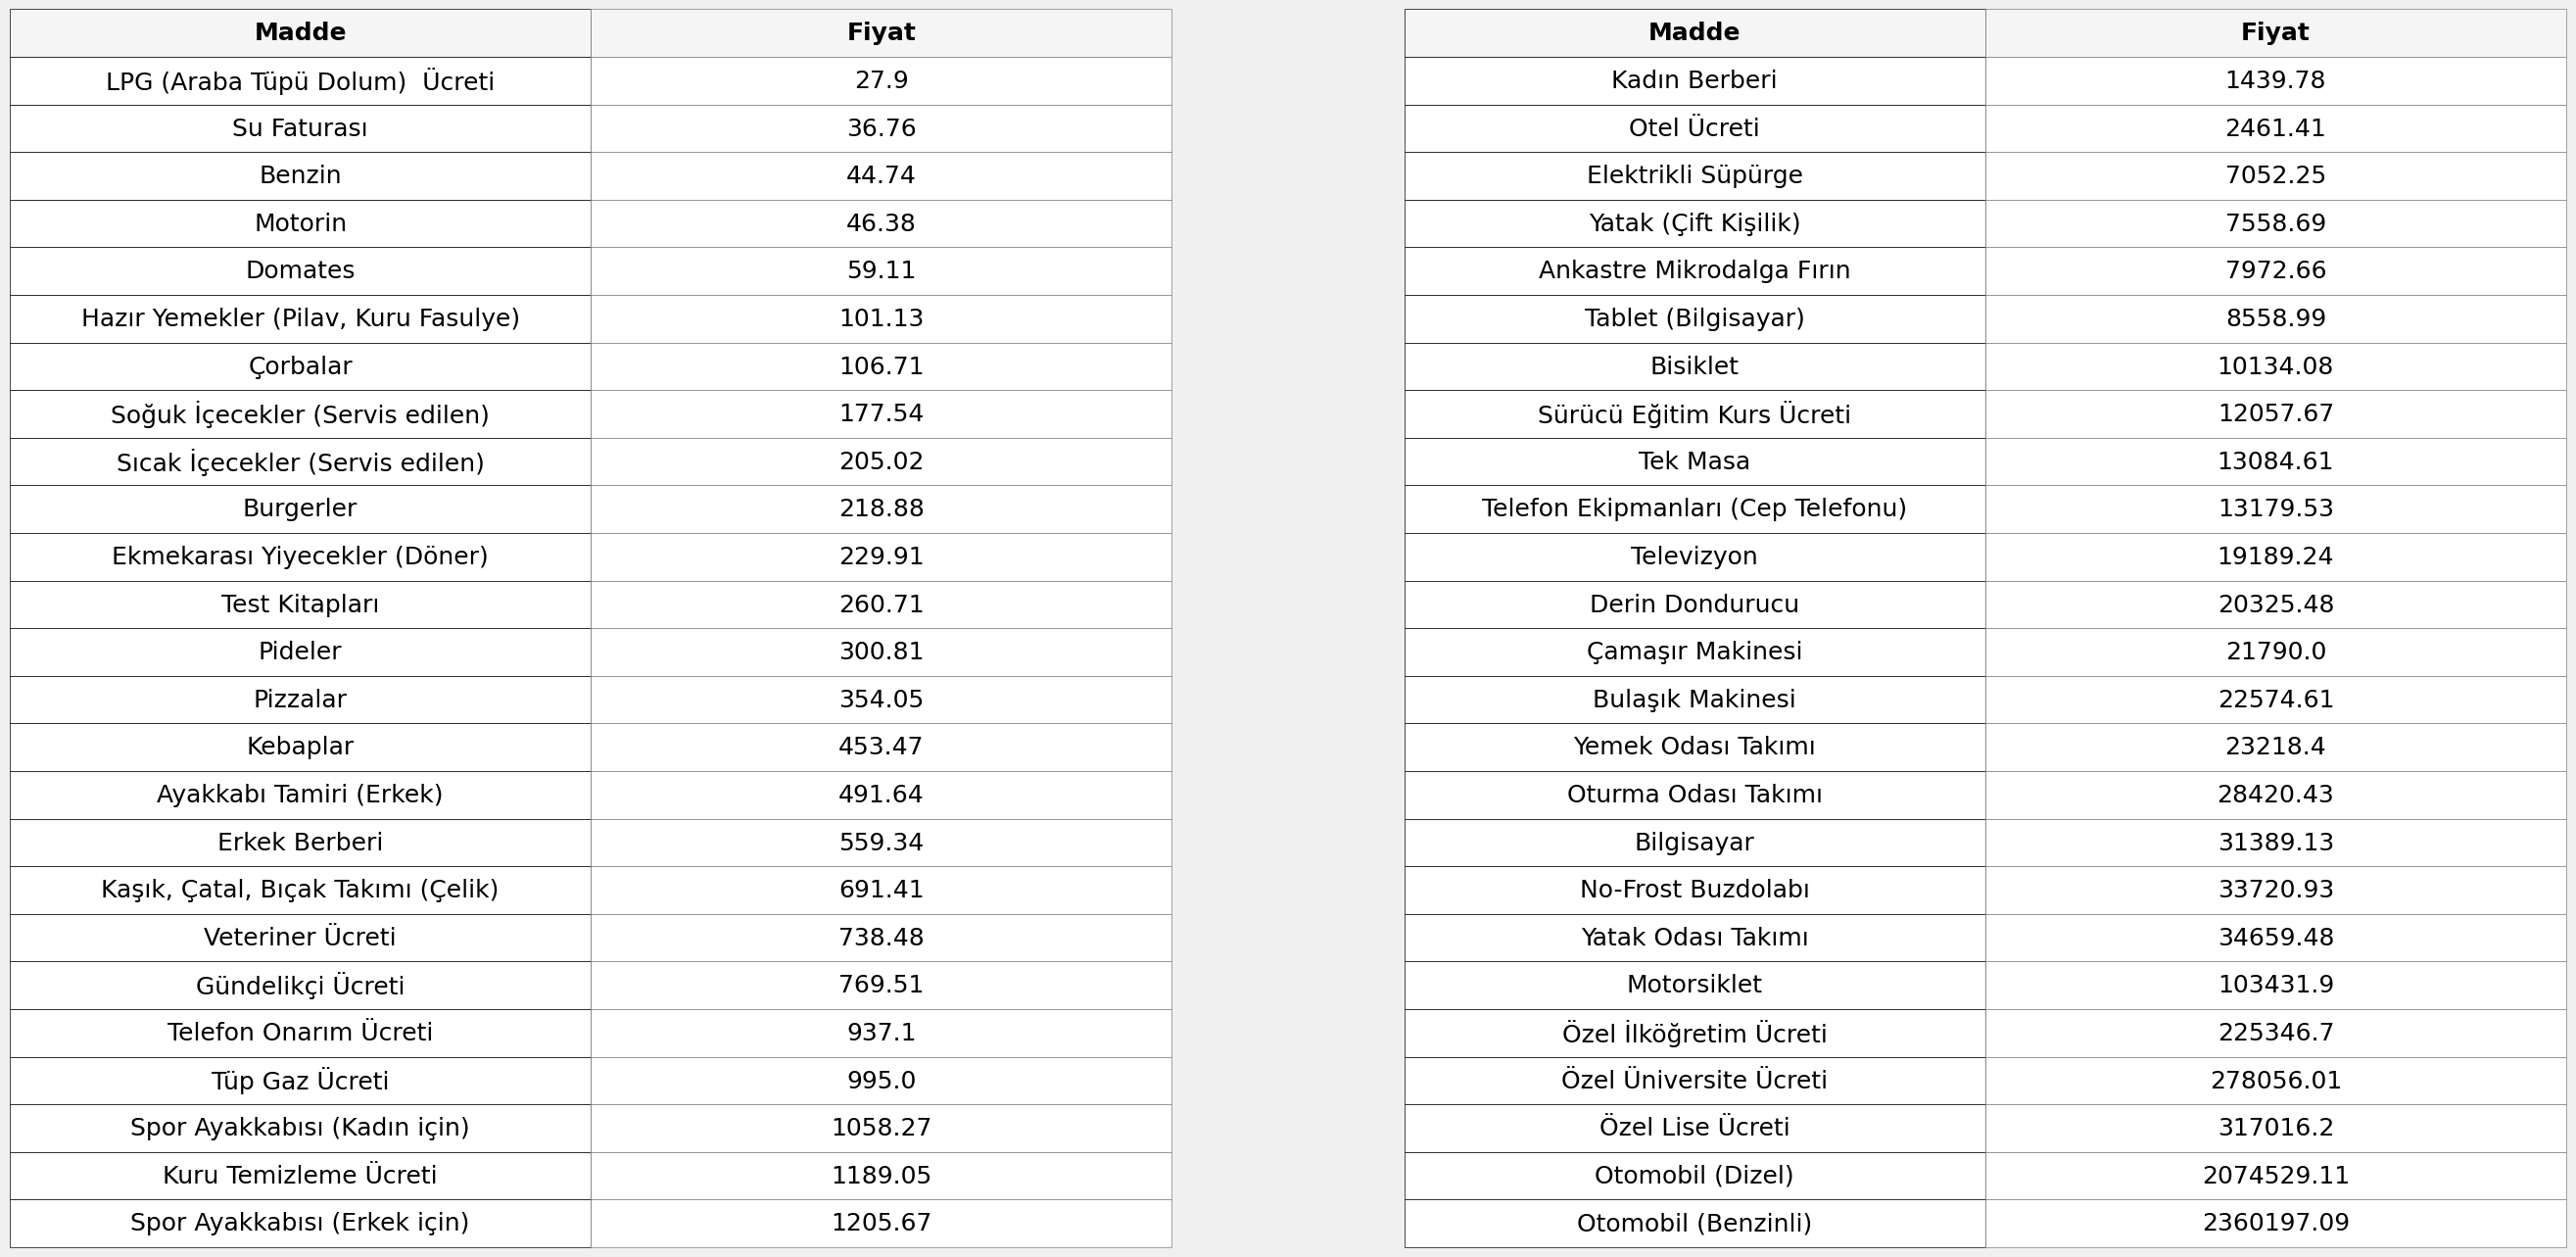

In [37]:
import matplotlib.pyplot as plt

# Veri örneği (fiyatlar yerine gerçek verinizi kullanmalısınız)
# fiyatlar = ...

# Tabloyu 2 parçaya bölelim
half = len(fiyatlar) // 2

# Grafik ve eksenleri oluştur
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))  # Yan yana 2 alt grafik

# İlk yarı
ax1.axis('off')  # Eksenleri kapat
table1 = ax1.table(cellText=fiyatlar.iloc[:half].values, colLabels=fiyatlar.columns, loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

for (i, j), cell in table1.get_celld().items():
    if i == 0:
        cell.set_fontsize(18)
        cell.set_text_props(weight='bold')
    else:
        cell.set_fontsize(18)
    if j == 0:
        cell.set_edgecolor('black')
    else:
        cell.set_edgecolor('gray')
    cell.set_height(0.05)

# İkinci yarı
ax2.axis('off')  # Eksenleri kapat
table2 = ax2.table(cellText=fiyatlar.iloc[half:].values, colLabels=fiyatlar.columns, loc='center', cellLoc='center', colColours=["#f5f5f5"]*2)

for (i, j), cell in table2.get_celld().items():
    if i == 0:
        cell.set_fontsize(18)
        cell.set_text_props(weight='bold')
    else:
        cell.set_fontsize(18)
    if j == 0:
        cell.set_edgecolor('black')
    else:
        cell.set_edgecolor('gray')
    cell.set_height(0.05)

# Grafik göster
plt.savefig("fiyatlar.png", dpi=300)



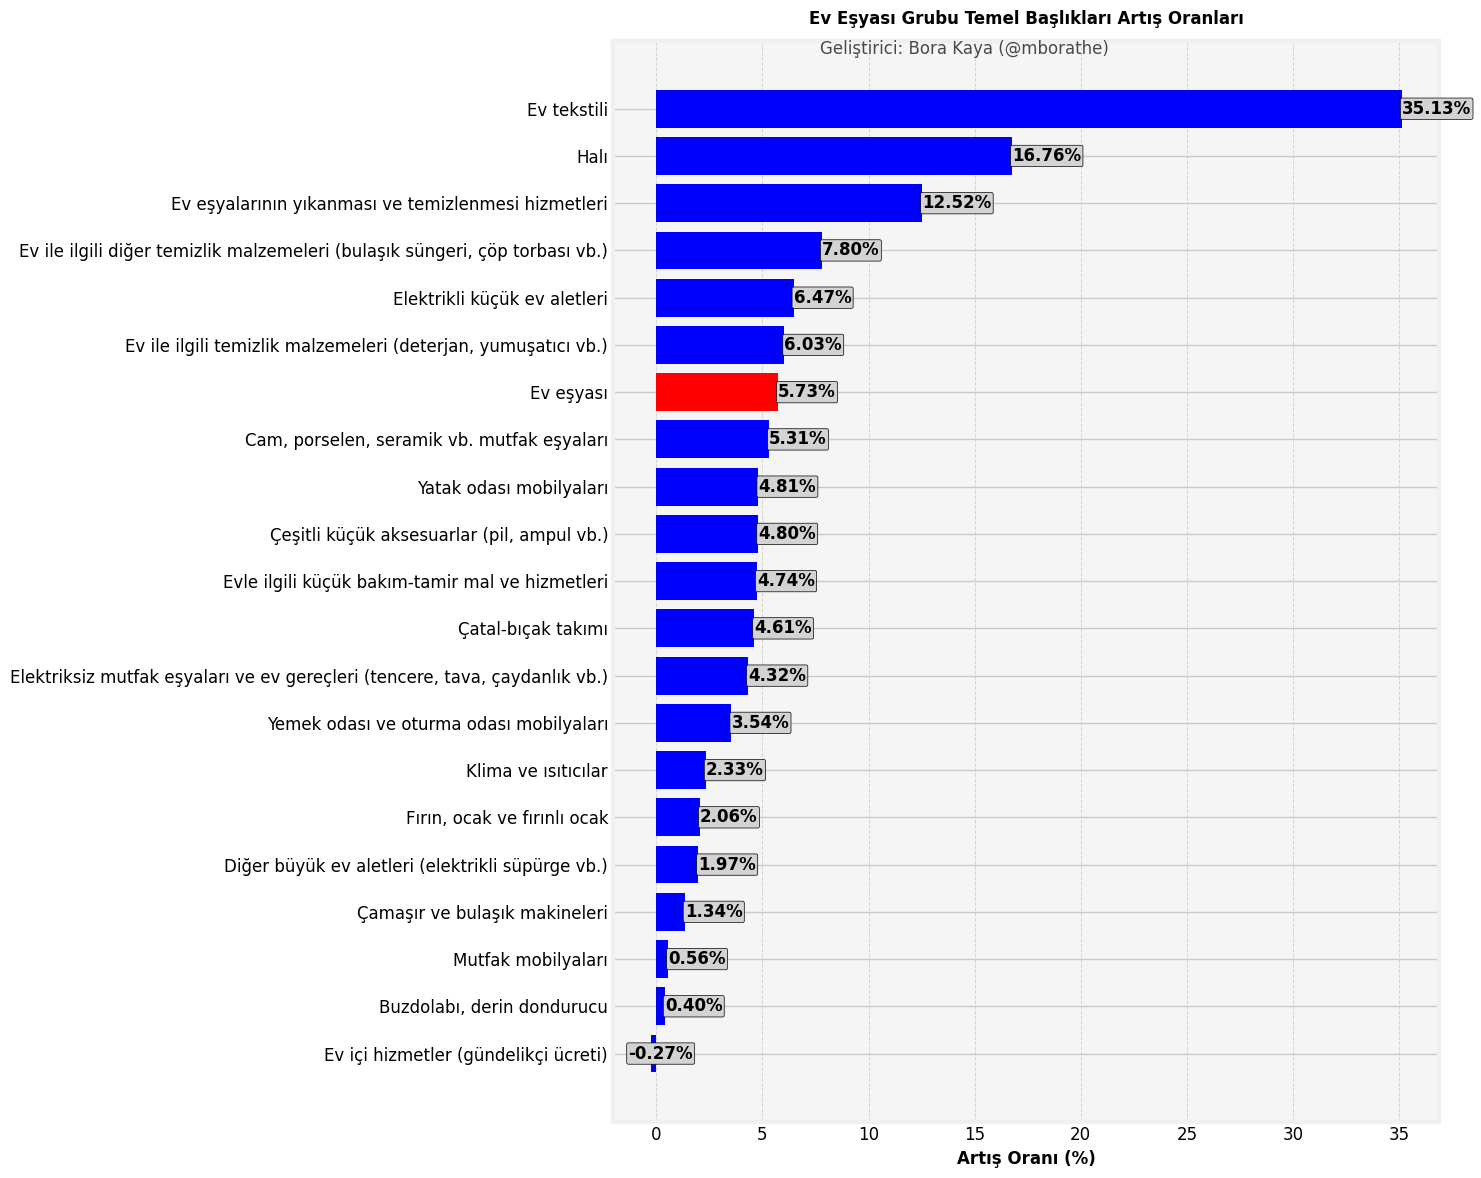

In [34]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]=="Ev eşyası"]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-02"].mean()/harcama_grupları[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc["Ev eşyası"]=(((gruplar["Ev eşyası"].loc["2025-02"].mean()/gruplar["Ev eşyası"].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == 'Ev eşyası' else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 12))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Ev Eşyası Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.65, 0.95, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"eveşyası.png", dpi=300)


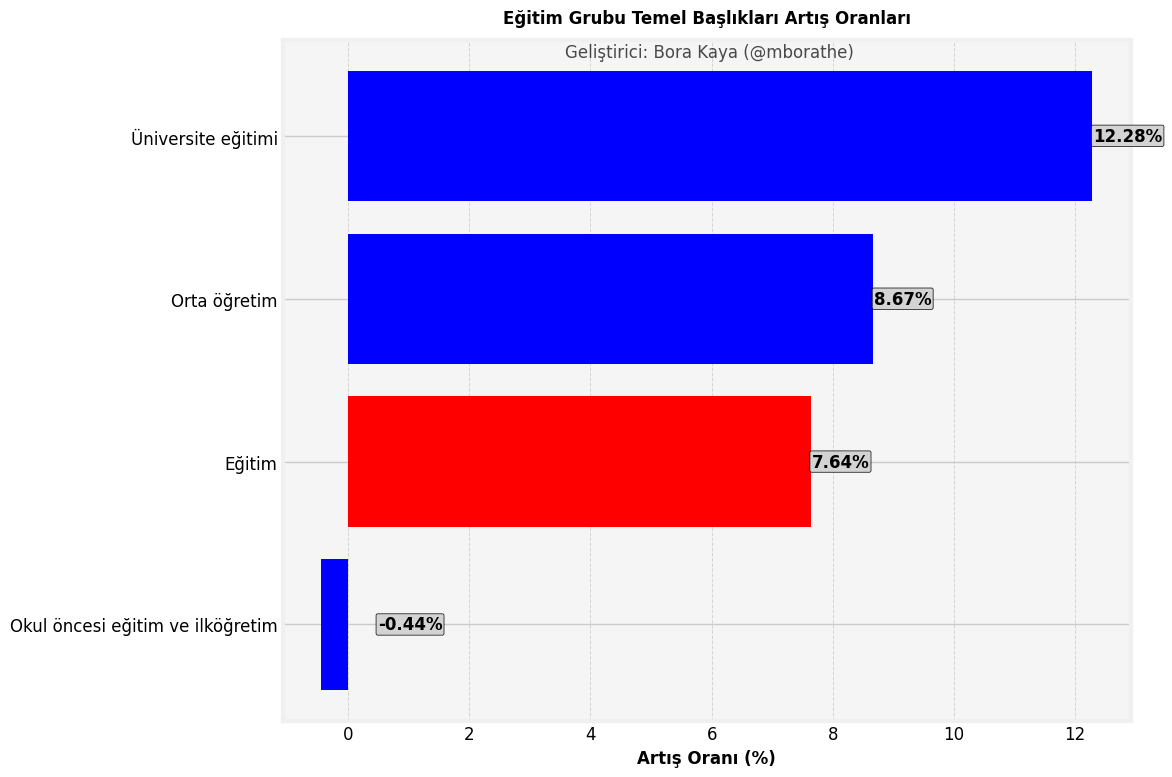

In [35]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]=="Eğitim"]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-02"].mean()/harcama_grupları[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc["Eğitim"]=(((gruplar["Eğitim"].loc["2025-02"].mean()/gruplar["Eğitim"].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == 'Eğitim' else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'Eğitim Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.60, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"eğitim.png", dpi=300)


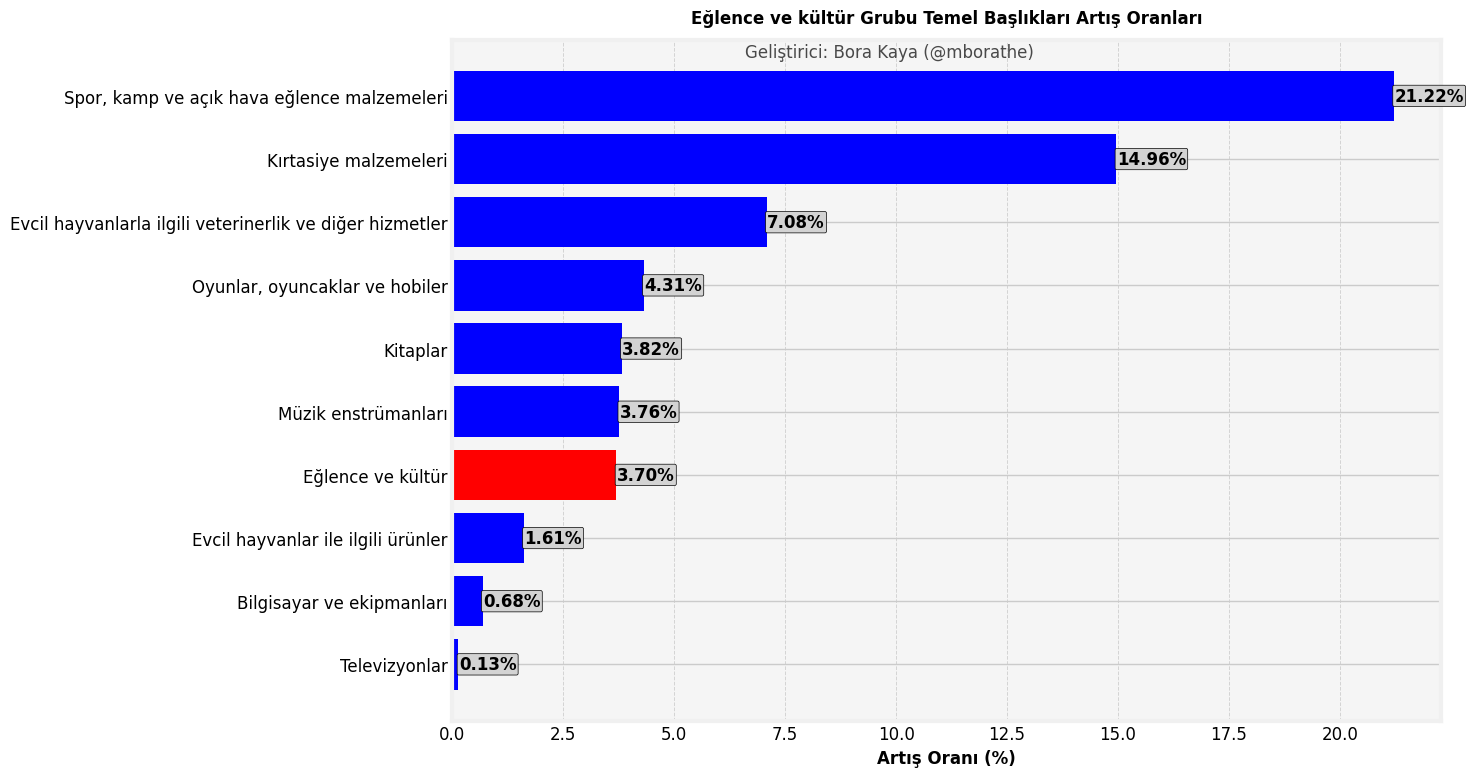

In [36]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Eğlence ve kültür"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-02"].mean()/harcama_grupları[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.60, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"eğlence.png", dpi=300)


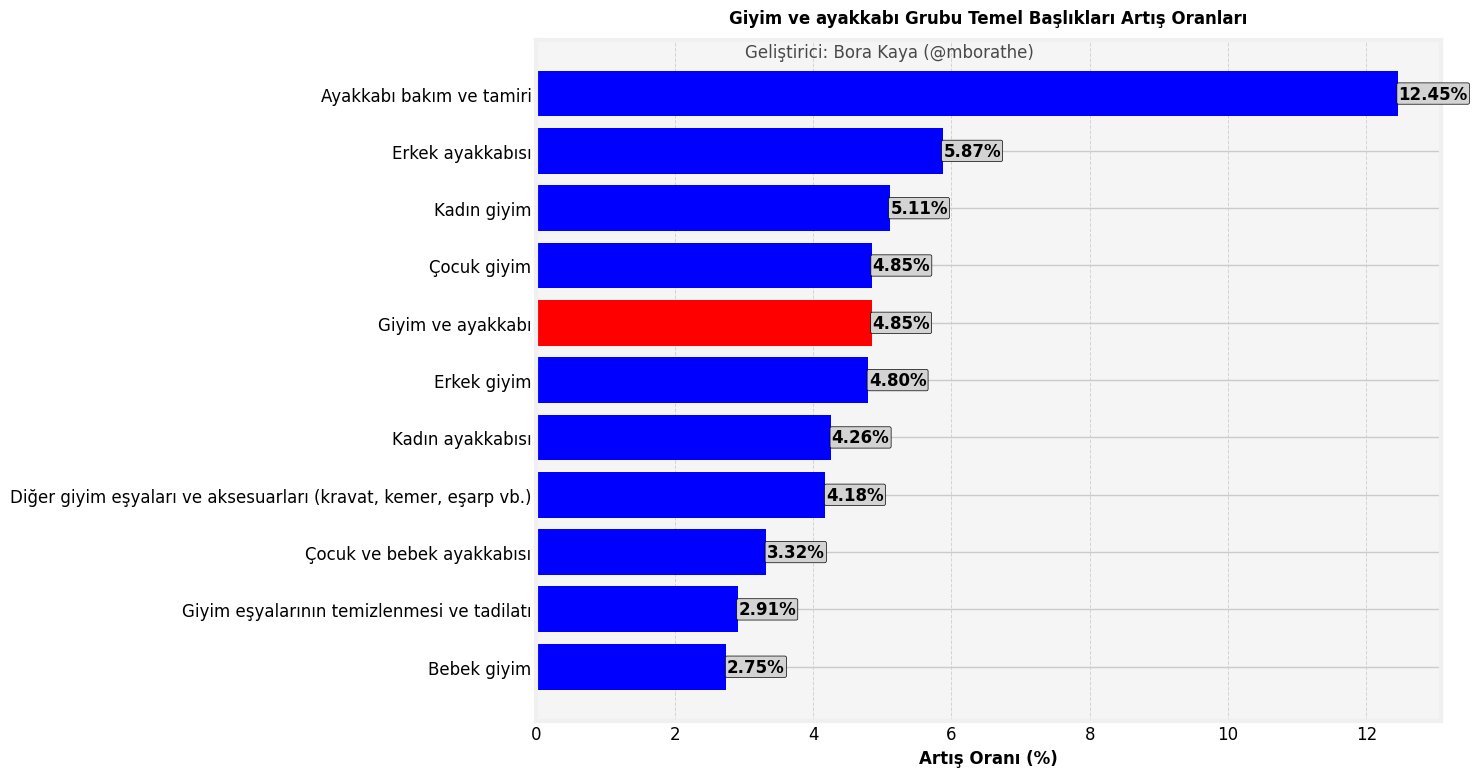

In [37]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Giyim ve ayakkabı"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-02"].mean()/harcama_grupları[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]

# İlk 42 karakteri almak için index etiketlerini kısaltma
shortened_index = [label[:100] for label in artıslar.index]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +2,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.60, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


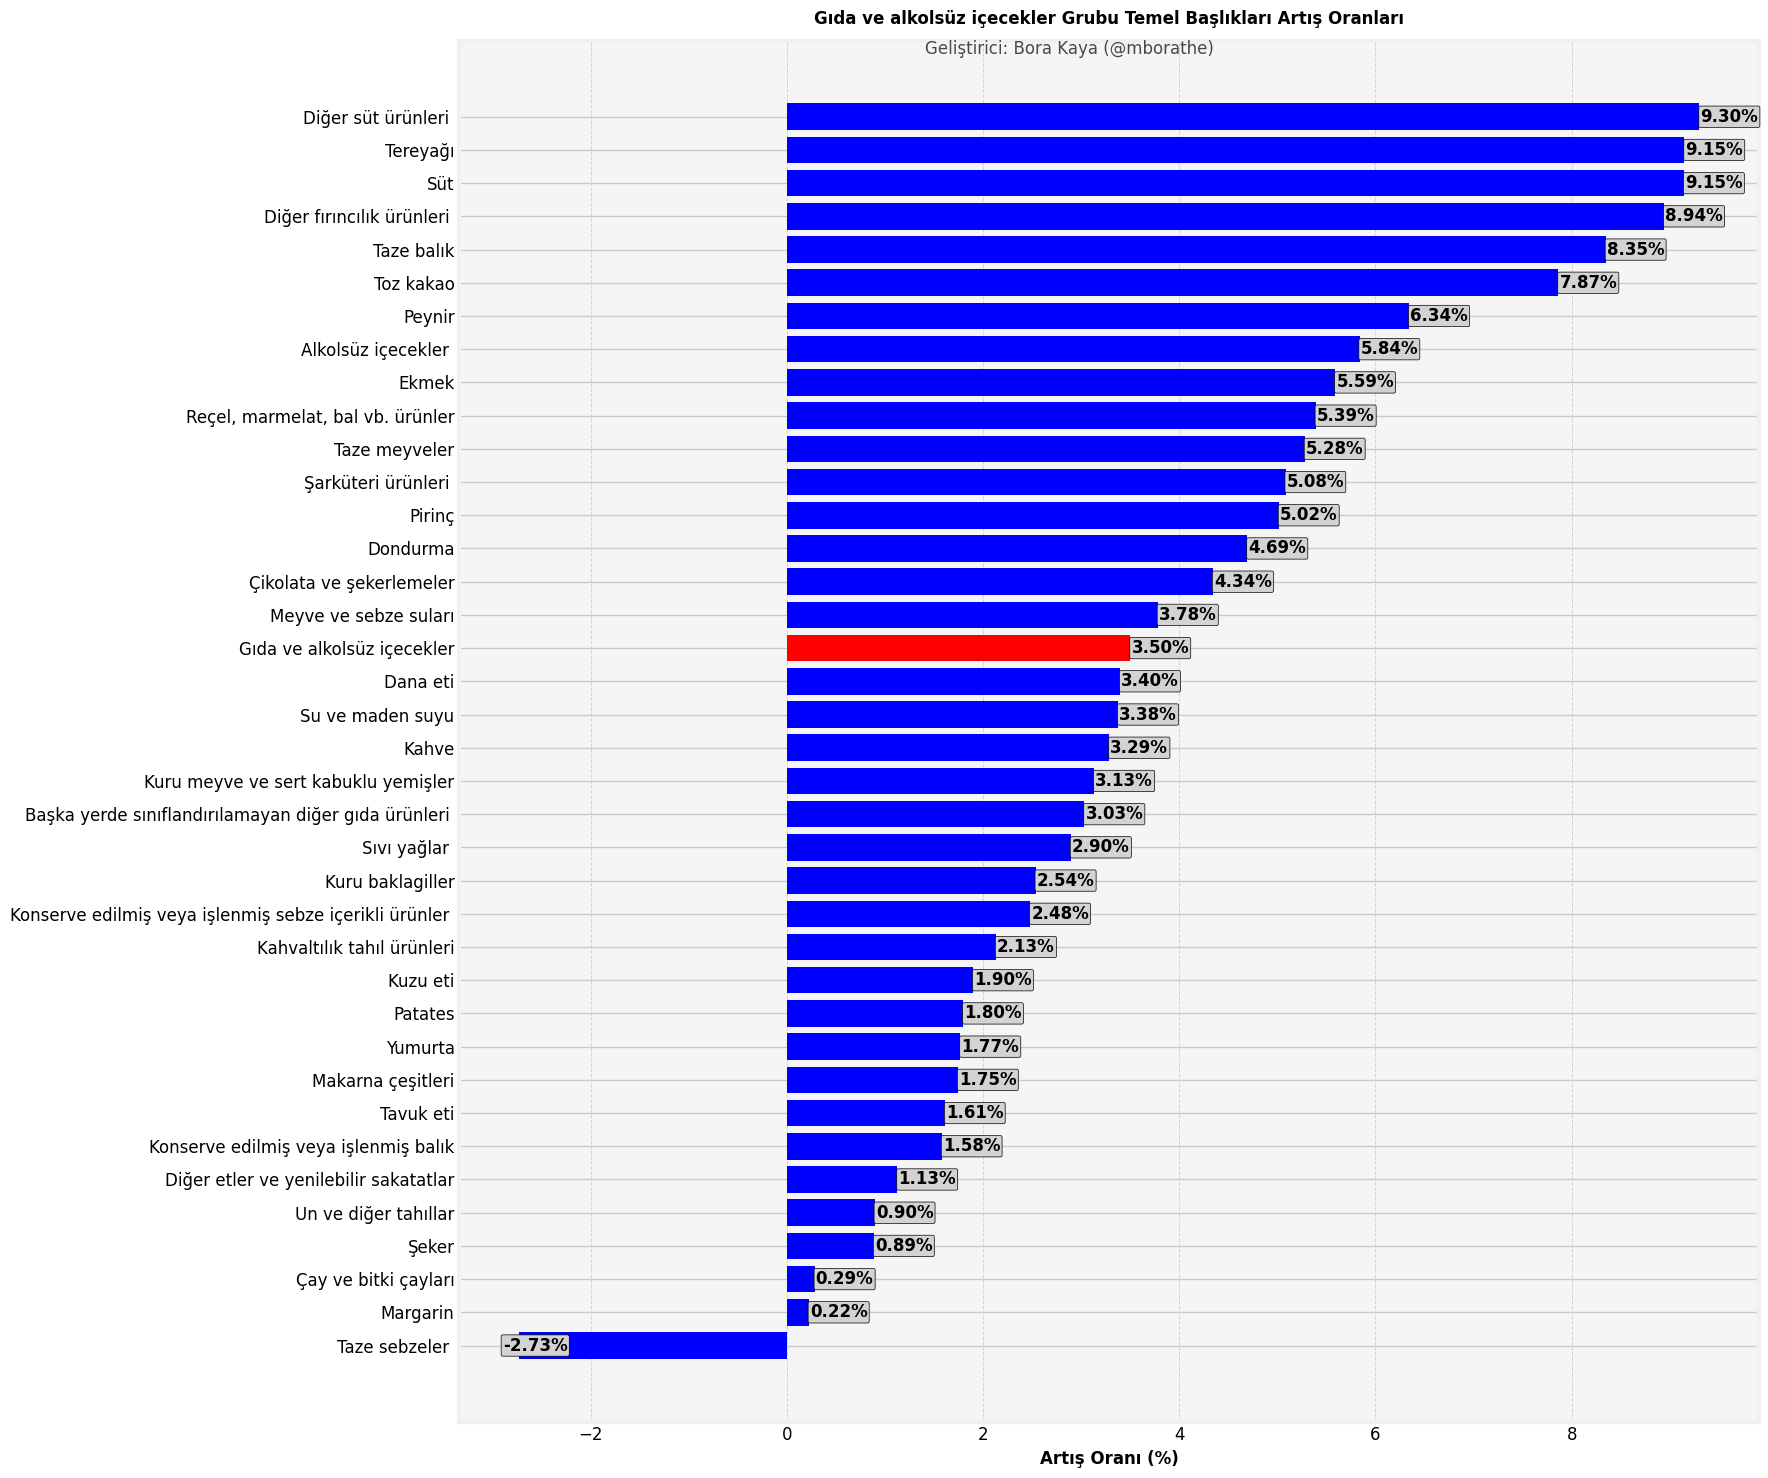

In [38]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Gıda ve alkolsüz içecekler"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-02"].mean()/harcama_grupları[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 15))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.96, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


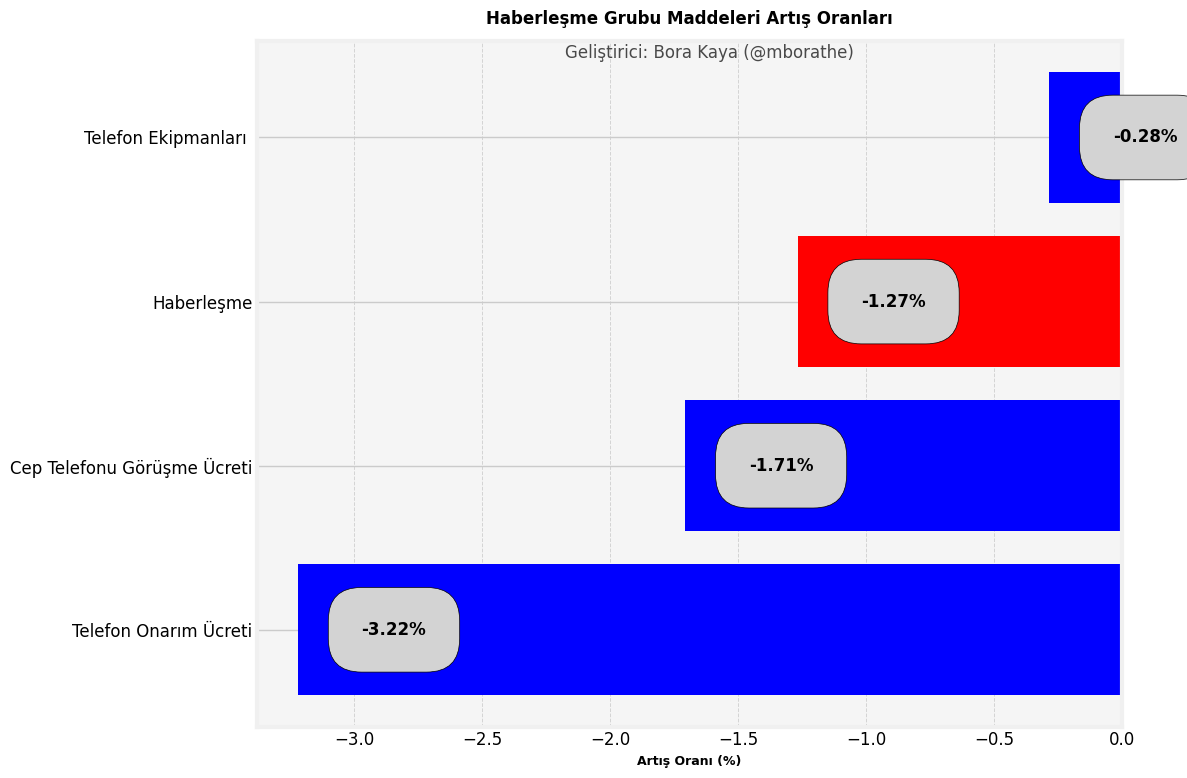

In [39]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Haberleşme"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-02"].mean()/endeksler[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=2')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=9, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


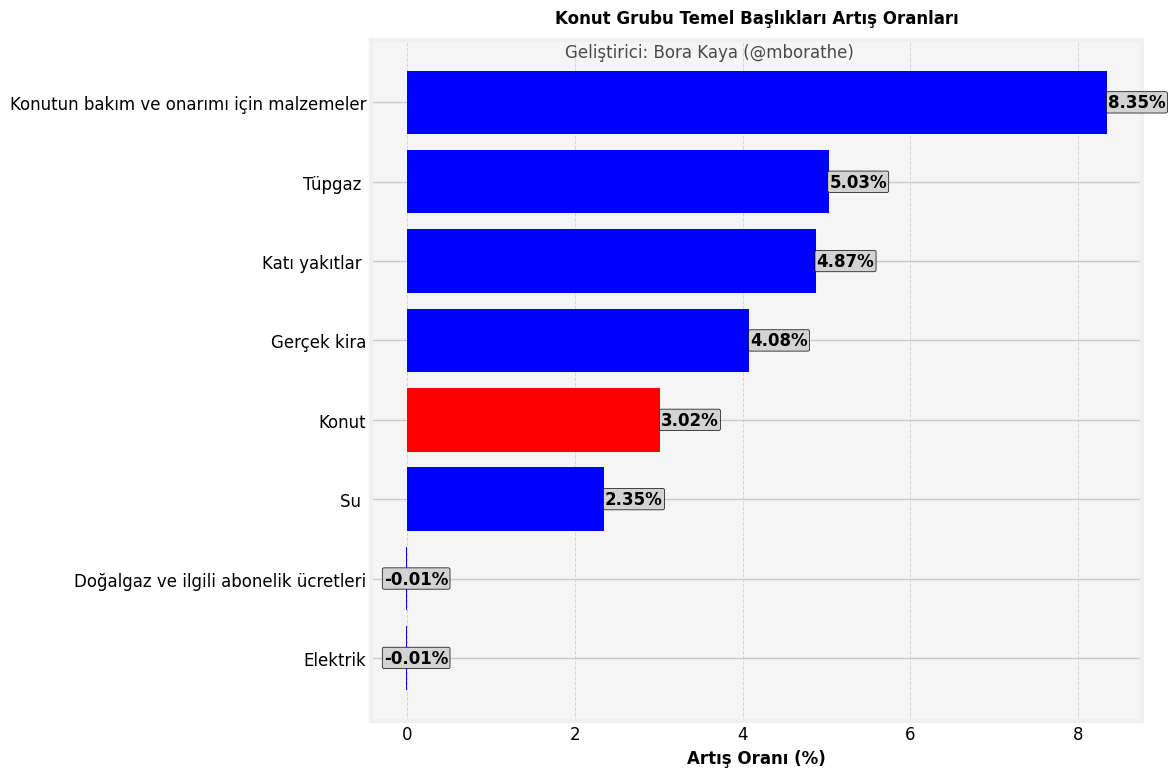

In [40]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Konut"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Grup"].unique()
artıslar=(((harcama_grupları[grup].loc["2025-02"].mean()/harcama_grupları[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Temel Başlıkları Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


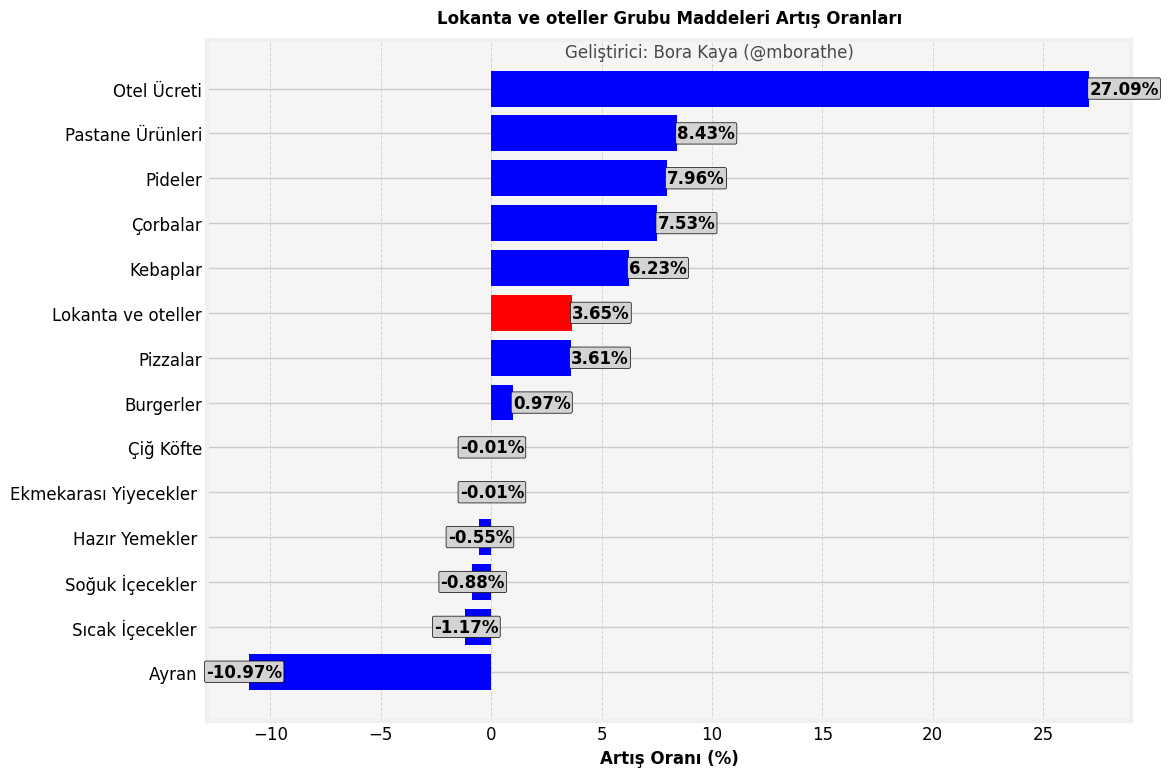

In [42]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Lokanta ve oteller"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-02"].mean()/endeksler[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [
    label.split('(')[0] if '(' in label else label[:60]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value >= 0 else xpos +1.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


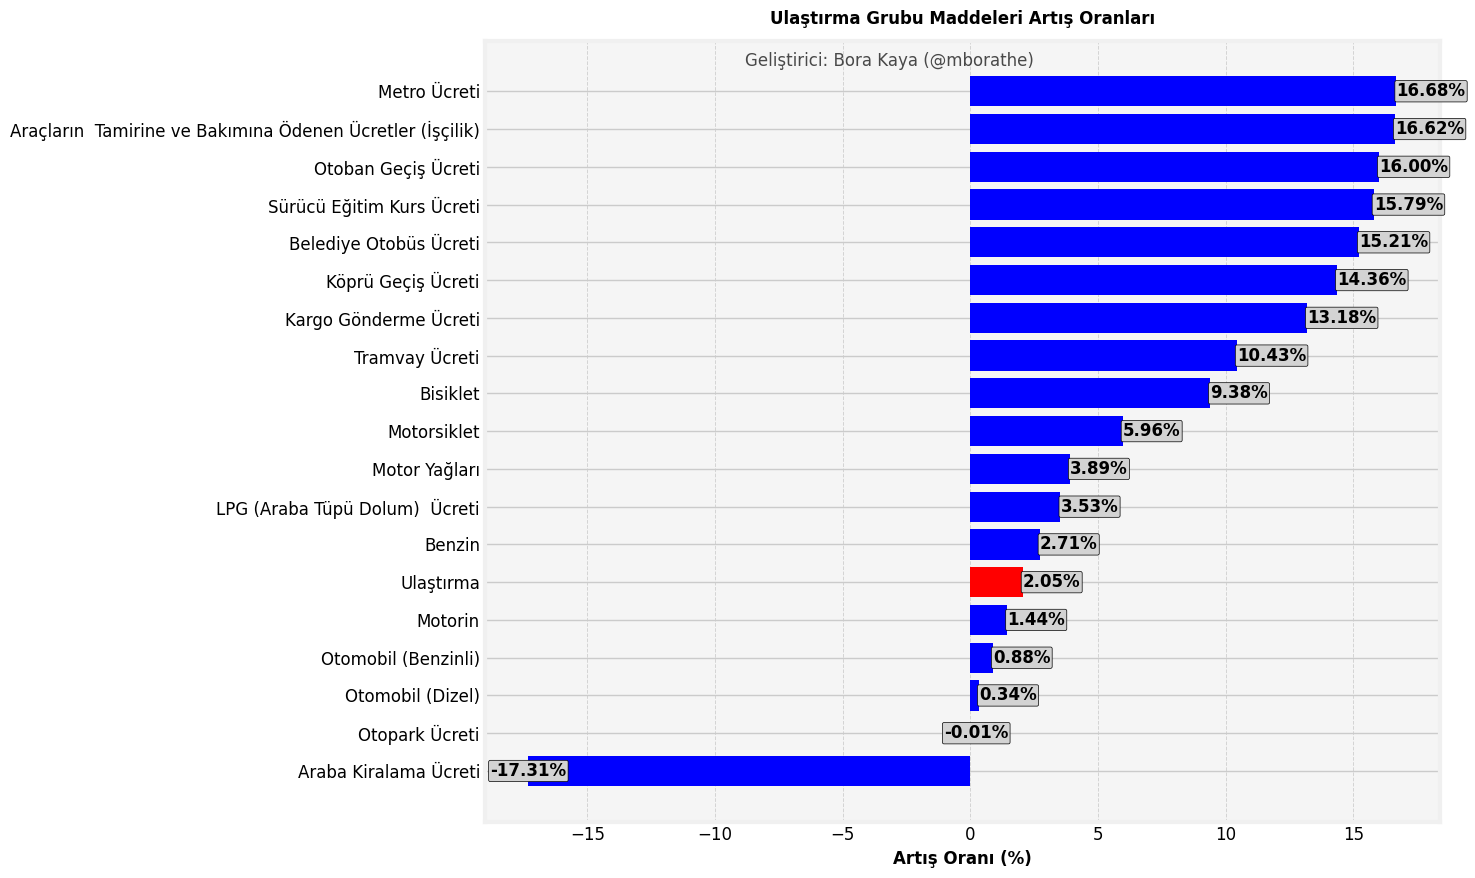

In [43]:
harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Ulaştırma"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-02"].mean()/endeksler[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]



# Modify the index shortening logic
shortened_index = [label[:80]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value > 0 else xpos +1.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.6, 0.92, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


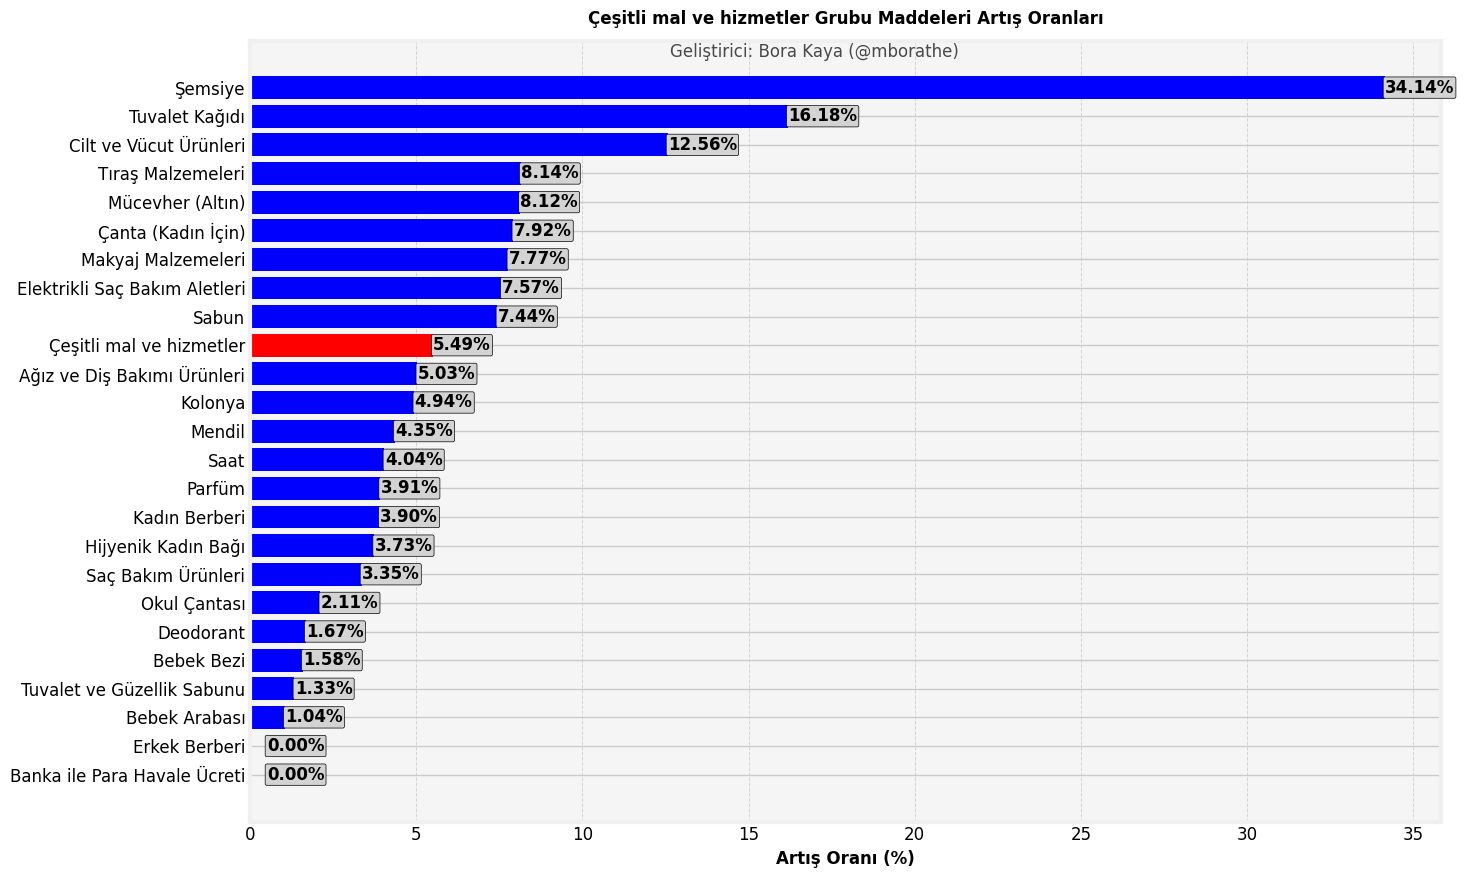

In [44]:

harcamaürünleri=pd.read_csv("harcamaürünleri1.csv",index_col=0)
ana="Çeşitli mal ve hizmetler"
grup=harcamaürünleri[harcamaürünleri["Ana Grup"]==ana]["Ürün"].unique()
artıslar=(((endeksler[grup].loc["2025-02"].mean()/endeksler[grup].loc["2025-01-01":"2025-01-24"].mean())-1)*100).sort_values()
artıslar.loc[ana]=(((gruplar[ana].loc["2025-02"].mean()/gruplar[ana].loc["2025-01-01":"2025-01-24"].mean())-1)*100)
artıslar=artıslar.sort_values()
colors = ['red' if label == ana else 'blue' for label in artıslar.index]
artıslar=artıslar.round(2)
artıslar.loc[artıslar == -0.01] = 0.0
# Modify the index shortening logic
shortened_index = [label[:80]  # Truncate at the first parenthesis if exists, else take first 60 characters
    for label in artıslar.index
]


values = list(artıslar)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.barh(shortened_index, values, color=colors)

# Etiket ekleme
for bar, value in zip(bars, values):
    xpos = bar.get_width()
    ax.text(
        xpos + 0.01 if value > 0 else xpos +0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{value:.2f}%',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontsize=12,
        fontweight='bold',
        color='black',
        bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.1')
    )

# FiveThirtyEight tarzı ayarlar
ax.set_facecolor('whitesmoke')  # Grafik arka planı
fig.patch.set_facecolor('white')  # Dış çerçeve arka planı
ax.grid(axis='x', color='lightgray', linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Başlık ve eksen ayarları
ax.set_title(f'{ana} Grubu Maddeleri Artış Oranları', fontsize=12, fontweight='bold', loc='center', pad=12)
ax.set_xlabel('Artış Oranı (%)', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Filigran ekleme
fig.text(0.55, 0.93, 'Geliştirici: Bora Kaya (@mborathe)', ha='center', va='center', fontsize=12, color='black', alpha=0.7, rotation=0)

# Çubuklar arasındaki boşluk azaltma
plt.subplots_adjust(left=0.35, right=0.95)
plt.tight_layout()

plt.savefig(f"{ana}.png", dpi=300)


In [45]:
data=pd.read_excel("C:/Users/Bora/Documents/GitHub/Enflasyon-SATRIM/harcama gruplarina gore endeks sonuclari (1).xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))

ağırlık=pd.read_excel("C:/Users/Bora/Documents/GitHub/Enflasyon-SATRIM/tuketici fiyat endeksi ana grup ve temel baslik agirliklari2025.xls")


ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
data

C:\Users\Bora\AppData\Local\Temp\ipykernel_7756\729621788.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))


,Pirinç,Un ve diğer tahıllar,Ekmek,"Diğer fırıncılık ürünleri (bisküvi, kek, kraker, yufka, baklava vb.)",Makarna çeşitleri,Kahvaltılık tahıl ürünleri,Dana eti,Kuzu eti,Tavuk eti,Diğer etler ve yenilebilir sakatatlar,...,"Kişisel hijyen ve bakım için kullanılan ürünler, kozmetikler","Mücevheratlar, saat ve kol saatleri",Seyahat malzemeleri ve diğer kişisel aksesuarlar,Başka yerde sınıflandırılmamış diğer kişisel aksesuarlar,Çocuk bakım hizmetleri (kreşler),Konut sigortası,Sağlık sigortası,Ulaştırma sigortası,Başka yerde sınıflandırılmayan diğer mali hizmetler (para havale ücreti vb.),"Başka yerde sınıflandırılmayan diğer hizmetler (noterlik, avukatlık hizmetleri vb.)"
2005-01-31,120.08,108.06,107.11,122.53,99.42,113.38,114.31,111.40,90.63,119.45,...,106.15,106.56,125.40,123.64,131.30,124.19,126.26,129.28,124.54,139.75
2005-02-28,120.87,108.49,106.85,123.56,100.08,113.03,115.62,118.71,88.03,120.30,...,107.07,101.73,124.47,123.60,129.70,125.90,126.26,134.10,126.59,139.88
2005-03-31,121.41,108.81,107.04,124.13,100.36,112.54,115.77,120.36,90.79,120.90,...,107.92,103.83,125.79,123.03,130.61,127.38,126.26,129.79,126.59,142.35
2005-04-30,122.72,108.36,106.70,124.42,99.56,112.51,115.24,119.77,107.88,120.77,...,108.46,106.22,126.44,121.91,131.08,128.11,119.78,120.74,128.68,144.01
2005-05-31,124.22,108.56,106.69,125.28,100.02,112.27,115.30,120.35,109.10,120.68,...,108.16,106.22,127.16,122.66,131.37,129.23,110.37,117.07,128.66,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,3672.82,2590.99,3350.15,3595.22,3243.60,1501.94,4835.83,5473.31,3319.80,6474.71,...,1402.20,12680.45,964,1869.82,4167.42,2151.74,1937.96,3912.74,223.11,3406.28
2024-10-31,3723.26,2776.59,3393.41,3752.97,3409.32,1440.33,4734.40,5490.95,3337.64,6900.97,...,1410.06,13020.23,964.67,1927.37,4275.01,2195.18,1970.87,4038.72,223.11,3613.57
2024-11-30,3749.45,2880.10,3408.20,3873.83,3535.84,1526.42,4732.50,5777.27,3447.49,7203.73,...,1447.37,12961.83,914.83,1906.45,4298.88,2219.49,2110.27,4155.28,223.11,3618.48
2024-12-31,3779.11,2944.61,3426.10,3976.71,3551.81,1677.18,4828.68,5946.97,3411.35,7447.38,...,1473.63,13045.01,942.38,1941.80,4315.02,2235.43,2174.36,4345.17,223.11,3626.90


In [46]:

data=data.rename(columns={"Başka yerde sınıflandırılamayan diğer gıda ürünleri (tuz, sirke, ketçap, mayonez vb.)":"Başka yerde sınıflandırılamayan diğer gıda ürünleri (tuz, kabartma maddeleri, sirke, ketçap, mayonez vb.)",
                          "Benzinli ve elektrikli otomobiller (sıfır km)":"Benzinli otomobiller (sıfır km)"})

In [47]:
data=data[harcama_grupları.columns].loc["2016":]

In [48]:
data.loc[pd.to_datetime("2025-02-28")]=(harcama_grupları.loc["2025-02"].mean()/harcama_grupları.loc["2025-01-01":"2025-01-24"].mean())*data.loc[pd.to_datetime("2025-01-31")]
data=data.sort_index()

In [49]:
from scipy import interpolate

for col in data.isna().sum().sort_values().index[-2:].values:

    valid_data = data[col].dropna()

    # x (geçerli tarihlerin indeksleri) ve y (geçerli değerler) verilerini alıyoruz
    x = np.array((valid_data.index - valid_data.index.min()).days)  # Gün cinsinden
    y = valid_data.values

    # Lineer interpolasyon fonksiyonu oluşturuyoruz
    interp_func = interpolate.interp1d(x, y, fill_value='extrapolate')

    # Tüm tarihleri kullanarak NaN değerlerini dolduruyoruz
    all_x = np.array((data[col].index - valid_data.index.min()).days)  # Tüm tarihlerin gün cinsinden indeksleri
    data[col] = interp_func(all_x)

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from statsmodels.tsa.x13 import x13_arima_analysis

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)



# Set the path to the X13-ARIMA executable
x13_path = r'C:\Users\Bora\Desktop\x13as'
spec = """
outlier {
    method = addone;
    types = ao tc ls;
}
"""


datasa = pd.DataFrame()
for col in data.columns:
    try:
            ayris = x13_arima_analysis(data[col], x12path=x13_path,outlier=False)
            datasa[col] = ayris.seasadj
    except Exception as e:
            datasa[col] = data[col]



In [58]:
medyan=datasa.pct_change().iloc[-1].sort_values().median()*100

C:\Users\Bora\AppData\Local\Temp\ipykernel_7756\1680949021.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  medyan=datasa.pct_change().iloc[-1].sort_values().median()*100


In [59]:
harcamağırlık=harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum()/harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum().sum()

In [60]:
datasa_aylık=datasa.pct_change().iloc[-1:]*100

for row in datasa_aylık.index:
    ay=datasa_aylık.loc[row]
    ay=ay.sort_values(ascending=False).iloc[int(len(datasa_aylık.columns)*0.15):int(-len(datasa_aylık.columns)*0.15)]
    ay=ay.sort_index()
    harcamağırlık=harcamağırlık.loc[(ay.index.values)]
    harcamağırlık=(harcamağırlık/harcamağırlık.sum())
    satrim=(np.sum(ay.values*harcamağırlık))


C:\Users\Bora\AppData\Local\Temp\ipykernel_7756\1810381525.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datasa_aylık=datasa.pct_change().iloc[-1:]*100


In [61]:
harcamağırlık=harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum()/harcamaürünleri[harcamaürünleri["Grup"].isin(datasa.columns)].groupby("Grup")["Ağırlık"].sum().sum()
satüfe=(datasa_aylık.iloc[-1]*harcamağırlık).sum()

In [62]:
tüfe_b_excluded=["Dana eti","Kuzu eti","Tavuk eti","Diğer etler ve yenilebilir sakatatlar","Taze balık","Konserve edilmiş veya işlenmiş balık","Yumurta","Taze meyveler","Taze sebzeler (patates hariç)",
                 "Elektrik","Doğalgaz ve ilgili abonelik ücretleri","Tüpgaz (ev tüpü)","Katı yakıtlar (odun, kömür)",
                 "Kişisel ulaştırma araçlarının yakıt ve yağları (benzin, motorin, motor yağı)","Mücevheratlar, saat ve kol saatleri","Üniversite eğitimi"]
tüfe_b=harcamaürünleri[~harcamaürünleri["Grup"].isin(tüfe_b_excluded)].drop_duplicates()

tüfe_b_sa=(datasa_aylık[tüfe_b["Grup"].unique()].iloc[-1]*tüfe_b.groupby("Grup")["Ağırlık"].sum()/tüfe_b.groupby("Grup")["Ağırlık"].sum().sum()).sum()

In [63]:
tüfe_c_excluded=[
                 "Elektrik","Doğalgaz ve ilgili abonelik ücretleri","Tüpgaz (ev tüpü)","Katı yakıtlar (odun, kömür)",
                 "Kişisel ulaştırma araçlarının yakıt ve yağları (benzin, motorin, motor yağı)","Mücevheratlar, saat ve kol saatleri",
                 'Alkolsüz içecekler (meşrubat, ayran vb.)',
       'Başka yerde sınıflandırılamayan diğer gıda ürünleri (tuz, kabartma maddeleri, sirke, ketçap, mayonez vb.)',
       'Dana eti', 'Diğer etler ve yenilebilir sakatatlar',
       'Diğer fırıncılık ürünleri (bisküvi, kek, kraker, yufka, baklava vb.)',
       'Diğer süt ürünleri (yoğurt, hazır sütlü tatlı vb.)', 'Dondurma',
       'Ekmek', 'Kahvaltılık tahıl ürünleri', 'Kahve',
       'Konserve edilmiş veya işlenmiş balık',
       'Konserve edilmiş veya işlenmiş sebze içerikli ürünler (salça, turşu, zeytin vb. dahil)',
       'Kuru baklagiller', 'Kuru meyve ve sert kabuklu yemişler',
       'Kuzu eti', 'Makarna çeşitleri', 'Margarin',
       'Meyve ve sebze suları', 'Patates', 'Peynir', 'Pirinç',
       'Reçel, marmelat, bal vb. ürünler', 'Su ve maden suyu', 'Süt',
       'Sıvı yağlar (zeytinyağı, ayçiçek yağı)', 'Tavuk eti',
       'Taze balık', 'Taze meyveler', 'Taze sebzeler (patates hariç)',
       'Tereyağı', 'Toz kakao', 'Un ve diğer tahıllar', 'Yumurta',
       'Çay ve bitki çayları', 'Çikolata ve şekerlemeler',
       'Şarküteri ürünleri (sucuk, sosis, salam vb.)', 'Şeker',"Üniversite eğitimi"]
tüfe_c=harcamaürünleri[~harcamaürünleri["Grup"].isin(tüfe_c_excluded)].drop_duplicates()
tüfe_c["Ağırlık"]=tüfe_c["Ağırlık"]/tüfe_c["Ağırlık"].sum()
tüfe_c=tüfe_c.drop_duplicates()

tüfe_c_sa=(datasa_aylık[tüfe_c["Grup"].unique()].iloc[-1]*tüfe_c.groupby("Grup")["Ağırlık"].sum()/tüfe_c.groupby("Grup")["Ağırlık"].sum().sum()).sum()

In [65]:
eğilim=pd.DataFrame()
eğilim["TÜFE"]=[satüfe]
eğilim["TÜFE B"]=[tüfe_b_sa]
eğilim["TÜFE C"]=[tüfe_c_sa]
eğilim["Medyan"]=[medyan]
eğilim["SATRIM"]=[satrim]
eğilim=eğilim.T
eğilim=eğilim.sort_values(by=0)
eğilim

,0
TÜFE,2.91
Medyan,3.20
SATRIM,3.29
TÜFE B,3.83
TÜFE C,3.99


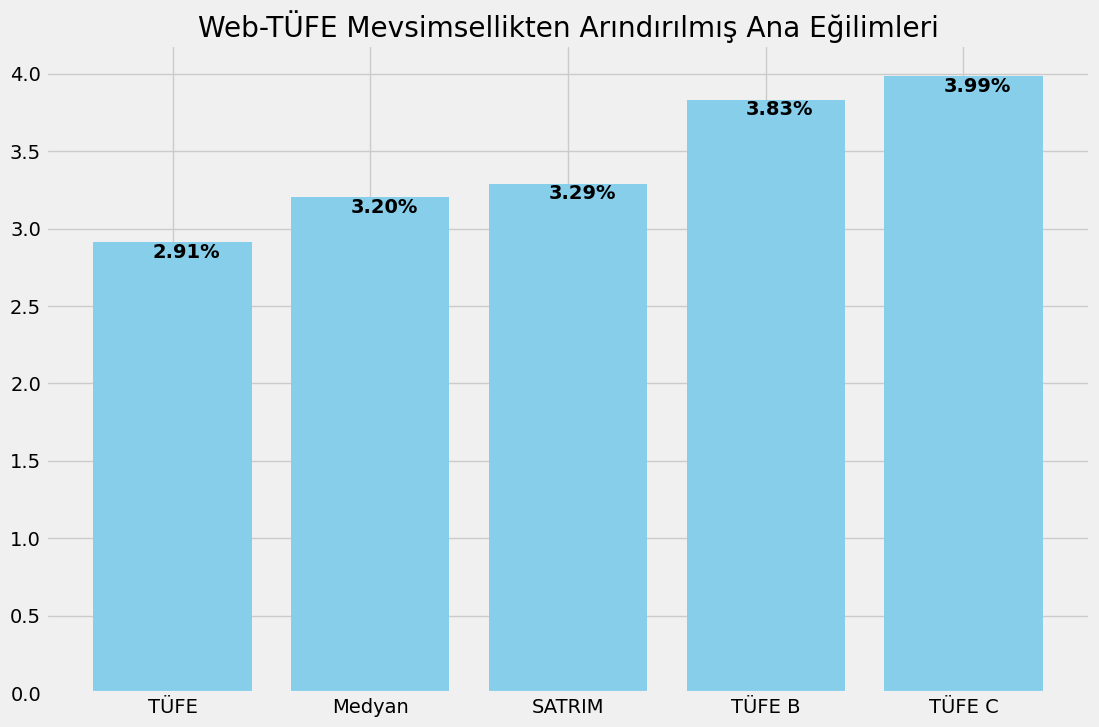

In [67]:
plt.figure(figsize=(12, 8))
plt.title("Web-TÜFE Mevsimsellikten Arındırılmış Ana Eğilimleri")
plt.bar(eğilim.sort_values(by=0).index, eğilim.sort_values(by=0)[0], color='skyblue')
for i, v in enumerate(eğilim.sort_values(by=0)[0]):
    plt.text(i - 0.1, v - 0.1, f'{v:.2f}%', color='black', fontweight='bold')
plt.savefig("eğilim.png", dpi=300)


In [68]:
ağırlıklar=pd.read_csv("ağırlıklartüfe.csv",index_col=0)


ağırlıklar

,Ağırlık,Ana Grup,Endeks_2024-12-31,Endeks_2025-01-06,Endeks_2025-01-07,Endeks_2025-01-09,Endeks_2025-01-10,Endeks_2025-01-11,Endeks_2025-01-12,Endeks_2025-01-13,...,Endeks_2025-02-15,Endeks_2025-02-16,Endeks_2025-02-17,Endeks_2025-02-18,Endeks_2025-02-19,Endeks_2025-02-20,Endeks_2025-02-21,Endeks_2025-02-22,Endeks_2025-02-23,Endeks_2025-02-24
Ürün,,,,,,,,,,,,,,,,,,,,,
Ampul,0.00,Ev eşyası,100.00,100.00,100.00,100.00,99.99,99.99,99.99,99.99,...,105.72,105.72,105.72,106.39,106.66,106.50,106.39,106.36,106.78,106.81
Ankastre Fırın,0.00,Ev eşyası,100.00,100.00,100.00,100.16,100.18,100.16,100.16,100.17,...,101.67,101.67,101.67,102.02,102.02,102.64,102.60,102.73,102.74,102.98
Ankastre Mikrodalga Fırın,0.00,Ev eşyası,100.00,100.00,100.00,100.00,99.98,99.93,99.86,99.85,...,102.35,102.35,101.76,102.02,102.02,103.19,103.41,103.60,103.04,103.42
Ankastre Ocak (Set Üstü),0.00,Ev eşyası,100.00,100.00,100.00,100.05,100.05,100.05,100.06,100.11,...,102.62,102.62,102.67,102.89,102.95,103.51,103.57,103.78,103.66,103.89
Antep Fıstığı,0.00,Gıda ve alkolsüz içecekler,100.00,103.00,103.00,103.00,103.00,103.00,103.00,103.00,...,102.34,102.34,102.34,104.78,102.34,102.34,102.93,102.93,102.93,102.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
İç Çamaşırı (Kadın için),0.00,Giyim ve ayakkabı,100.00,100.00,100.01,100.02,100.01,100.02,100.00,100.00,...,108.58,108.58,108.58,110.06,109.98,109.57,111.04,110.72,112.28,112.79
İç çamaşırı (Çocuk için),0.00,Giyim ve ayakkabı,100.00,100.00,100.00,100.02,100.01,100.01,100.01,100.01,...,106.89,106.89,106.89,106.63,106.53,101.91,102.32,102.40,102.55,102.71
Şeftali,0.00,Gıda ve alkolsüz içecekler,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,102.99,102.65,102.66,103.22,103.41,104.21,104.29,104.29,104.51,104.10
